<a href="https://colab.research.google.com/github/KingNook/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/KingNook/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

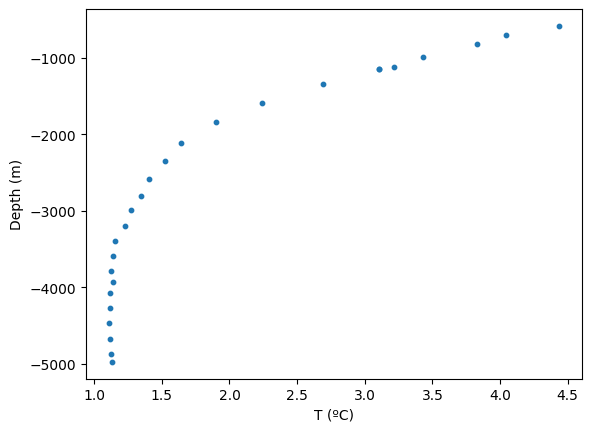

In [ ]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2025-11-12 23:07:18,208 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


Text(0, 0.5, 'Depth (m)')

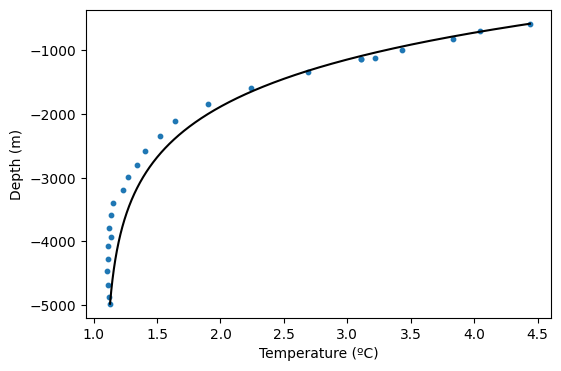

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa = 1e-4 # 1e-7 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

**Steady Advection / Diffusion**

Through the extremely rigorous process of guessing numbers, we see that choosing $\kappa\approx 1e-4$ gives a reasonably good fit to the data (ie setting the diffusivity to around 3 orders of magnitude larger than the molecular diffusivity).

This model fits the data reasonably well for 'shallower' waters (from around -1500m upwards), but consistently predicts a higher temperature for lower depths. In particular, we see the Temperature is nearly constant from around -3800m downwards which the model does not capture at all.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2025-11-12 23:07:26,893 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


Text(0, 0.5, 'Depth (m)')

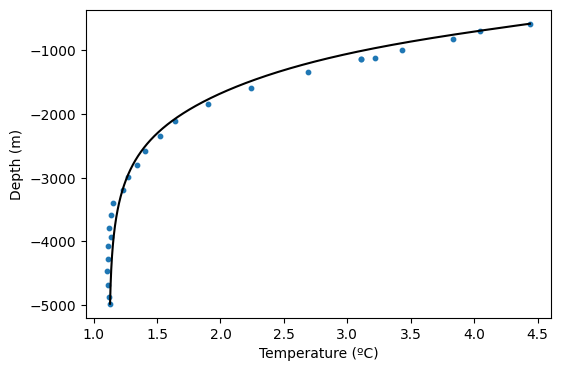

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa_0 = 8.6e-4 - 1e-5
kappa_bg = 1e-5
D = 5e+3
l = 667

## Varying profile
# kappa_0 = 5e-5 ## less overall change
# l = 200 ## faster decay

kappa['g'] = kappa_bg + (kappa_0 - kappa_bg)*np.exp((-D - z)/l) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

**Comments about balance in this case**

The closeness of fit even when $w=0$ seems to suggest that the density profile can largely be described by depth-dependent turbulent diffusion alone, with downwelling playing only a small part.

We see that choosing $w= 1\times 10^{-8} ms^{-1}$ gives an improved fit, especially for deeper waters, somewhat capturing the near-constant temperatures at the deepest part. Exactly optimal $w$ is somewhat hard to judge without quantitative analysis, but by eye, it seems to be in the region of $1\times10^{-8}ms^{-1}$.

**Varying the profile of $\kappa(z)$**

On varying the parameters of $\kappa$, we see the optimal value of $w$ does not seem to change, remaining at around $1\times 10^{-8} ms^{-1}$ - if we set $w$ to 0 again, we can change parameters to see that the profile changes significantly and thus to confirm that the downwelling velocity, $w$, is having an effect.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2025-11-12 23:07:30,580 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


INFO:__main__:Starting main loop


2025-11-12 23:07:30,589 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 23:07:31,272 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 23:07:31,301 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 23:07:31,333 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 23:07:31,363 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 23:07:31,392 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 23:07:31,420 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 23:07:31,450 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 23:07:31,478 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 23:07:31,507 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 23:07:31,538 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 23:07:31,571 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 23:07:31,601 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 23:07:31,632 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 23:07:31,661 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 23:07:31,692 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 23:07:31,729 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 23:07:31,759 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 23:07:31,788 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 23:07:31,823 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 23:07:31,863 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 23:07:31,894 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 23:07:31,924 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 23:07:31,952 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 23:07:31,983 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 23:07:32,013 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 23:07:32,046 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 23:07:32,077 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 23:07:32,107 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 23:07:32,141 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 23:07:32,171 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 23:07:32,200 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 23:07:32,229 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 23:07:32,259 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 23:07:32,288 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 23:07:32,316 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 23:07:32,347 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 23:07:32,377 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 23:07:32,406 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 23:07:32,435 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 23:07:32,465 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 23:07:32,495 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 23:07:32,525 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 23:07:32,553 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 23:07:32,584 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 23:07:32,613 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 23:07:32,641 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 23:07:32,670 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 23:07:32,701 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 23:07:32,730 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 23:07:32,762 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 23:07:32,797 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 23:07:32,826 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 23:07:32,861 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 23:07:32,904 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 23:07:32,935 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 23:07:32,964 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 23:07:32,995 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 23:07:33,029 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 23:07:33,062 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 23:07:33,090 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 23:07:33,126 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 23:07:33,159 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 23:07:33,188 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 23:07:33,216 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 23:07:33,246 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 23:07:33,276 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 23:07:33,305 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 23:07:33,334 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 23:07:33,364 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 23:07:33,399 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 23:07:33,436 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 23:07:33,468 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 23:07:33,500 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 23:07:33,532 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 23:07:33,563 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 23:07:33,593 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 23:07:33,621 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 23:07:33,644 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 23:07:33,647 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 23:07:33,650 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2491 sec


2025-11-12 23:07:33,654 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2491 sec


INFO:solvers:Warmup time (iter 0-10): 0.7061 sec


2025-11-12 23:07:33,658 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.7061 sec


INFO:solvers:Run time (iter 10-end): 2.348 sec


2025-11-12 23:07:33,661 solvers 0/1 INFO :: Run time (iter 10-end): 2.348 sec


INFO:solvers:CPU time (iter 10-end): 0.0006524 cpu-hr


2025-11-12 23:07:33,663 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006524 cpu-hr


INFO:solvers:Speed: 5.597e+06 mode-stages/cpu-sec


2025-11-12 23:07:33,666 solvers 0/1 INFO :: Speed: 5.597e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

In [ ]:
!pip3 install ffmpeg

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-1 # 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=5000 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


2025-11-12 23:07:44,095 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s


INFO:__main__:Starting main loop


2025-11-12 23:07:44,100 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 23:07:44,147 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 23:07:44,177 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 23:07:44,205 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 23:07:44,248 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 23:07:44,279 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 23:07:44,309 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 23:07:44,340 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 23:07:44,372 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 23:07:44,403 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 23:07:44,433 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 23:07:44,465 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 23:07:44,494 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 23:07:44,523 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 23:07:44,552 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 23:07:44,580 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 23:07:44,609 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 23:07:44,639 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 23:07:44,673 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 23:07:44,701 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 23:07:44,730 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 23:07:44,762 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 23:07:44,793 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 23:07:44,823 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 23:07:44,853 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 23:07:44,883 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 23:07:44,913 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 23:07:44,945 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 23:07:44,977 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 23:07:45,008 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 23:07:45,043 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 23:07:45,073 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 23:07:45,101 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 23:07:45,132 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 23:07:45,163 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 23:07:45,193 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 23:07:45,226 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 23:07:45,260 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 23:07:45,302 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 23:07:45,330 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 23:07:45,361 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 23:07:45,392 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 23:07:45,424 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 23:07:45,454 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 23:07:45,486 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 23:07:45,525 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 23:07:45,577 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 23:07:45,626 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 23:07:45,674 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 23:07:45,723 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 23:07:45,764 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 23:07:45,809 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 23:07:45,850 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 23:07:45,897 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 23:07:45,939 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 23:07:45,989 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 23:07:46,036 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 23:07:46,084 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 23:07:46,130 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 23:07:46,179 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 23:07:46,227 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 23:07:46,275 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 23:07:46,326 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 23:07:46,367 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 23:07:46,423 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 23:07:46,464 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 23:07:46,506 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 23:07:46,549 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 23:07:46,590 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 23:07:46,628 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 23:07:46,666 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 23:07:46,707 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 23:07:46,747 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 23:07:46,786 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 23:07:46,826 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 23:07:46,866 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 23:07:46,907 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 23:07:46,947 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:__main__:Iteration=771, Time=1.505859e+03, dt=1.953125e+00


2025-11-12 23:07:46,987 __main__ 0/1 INFO :: Iteration=771, Time=1.505859e+03, dt=1.953125e+00


INFO:__main__:Iteration=781, Time=1.525391e+03, dt=1.953125e+00


2025-11-12 23:07:47,030 __main__ 0/1 INFO :: Iteration=781, Time=1.525391e+03, dt=1.953125e+00


INFO:__main__:Iteration=791, Time=1.544922e+03, dt=1.953125e+00


2025-11-12 23:07:47,074 __main__ 0/1 INFO :: Iteration=791, Time=1.544922e+03, dt=1.953125e+00


INFO:__main__:Iteration=801, Time=1.564453e+03, dt=1.953125e+00


2025-11-12 23:07:47,119 __main__ 0/1 INFO :: Iteration=801, Time=1.564453e+03, dt=1.953125e+00


INFO:__main__:Iteration=811, Time=1.583984e+03, dt=1.953125e+00


2025-11-12 23:07:47,160 __main__ 0/1 INFO :: Iteration=811, Time=1.583984e+03, dt=1.953125e+00


INFO:__main__:Iteration=821, Time=1.603516e+03, dt=1.953125e+00


2025-11-12 23:07:47,200 __main__ 0/1 INFO :: Iteration=821, Time=1.603516e+03, dt=1.953125e+00


INFO:__main__:Iteration=831, Time=1.623047e+03, dt=1.953125e+00


2025-11-12 23:07:47,241 __main__ 0/1 INFO :: Iteration=831, Time=1.623047e+03, dt=1.953125e+00


INFO:__main__:Iteration=841, Time=1.642578e+03, dt=1.953125e+00


2025-11-12 23:07:47,281 __main__ 0/1 INFO :: Iteration=841, Time=1.642578e+03, dt=1.953125e+00


INFO:__main__:Iteration=851, Time=1.662109e+03, dt=1.953125e+00


2025-11-12 23:07:47,323 __main__ 0/1 INFO :: Iteration=851, Time=1.662109e+03, dt=1.953125e+00


INFO:__main__:Iteration=861, Time=1.681641e+03, dt=1.953125e+00


2025-11-12 23:07:47,363 __main__ 0/1 INFO :: Iteration=861, Time=1.681641e+03, dt=1.953125e+00


INFO:__main__:Iteration=871, Time=1.701172e+03, dt=1.953125e+00


2025-11-12 23:07:47,402 __main__ 0/1 INFO :: Iteration=871, Time=1.701172e+03, dt=1.953125e+00


INFO:__main__:Iteration=881, Time=1.720703e+03, dt=1.953125e+00


2025-11-12 23:07:47,445 __main__ 0/1 INFO :: Iteration=881, Time=1.720703e+03, dt=1.953125e+00


INFO:__main__:Iteration=891, Time=1.740234e+03, dt=1.953125e+00


2025-11-12 23:07:47,496 __main__ 0/1 INFO :: Iteration=891, Time=1.740234e+03, dt=1.953125e+00


INFO:__main__:Iteration=901, Time=1.759766e+03, dt=1.953125e+00


2025-11-12 23:07:47,543 __main__ 0/1 INFO :: Iteration=901, Time=1.759766e+03, dt=1.953125e+00


INFO:__main__:Iteration=911, Time=1.779297e+03, dt=1.953125e+00


2025-11-12 23:07:47,582 __main__ 0/1 INFO :: Iteration=911, Time=1.779297e+03, dt=1.953125e+00


INFO:__main__:Iteration=921, Time=1.798828e+03, dt=1.953125e+00


2025-11-12 23:07:47,623 __main__ 0/1 INFO :: Iteration=921, Time=1.798828e+03, dt=1.953125e+00


INFO:__main__:Iteration=931, Time=1.818359e+03, dt=1.953125e+00


2025-11-12 23:07:47,664 __main__ 0/1 INFO :: Iteration=931, Time=1.818359e+03, dt=1.953125e+00


INFO:__main__:Iteration=941, Time=1.837891e+03, dt=1.953125e+00


2025-11-12 23:07:47,706 __main__ 0/1 INFO :: Iteration=941, Time=1.837891e+03, dt=1.953125e+00


INFO:__main__:Iteration=951, Time=1.857422e+03, dt=1.953125e+00


2025-11-12 23:07:47,753 __main__ 0/1 INFO :: Iteration=951, Time=1.857422e+03, dt=1.953125e+00


INFO:__main__:Iteration=961, Time=1.876953e+03, dt=1.953125e+00


2025-11-12 23:07:47,806 __main__ 0/1 INFO :: Iteration=961, Time=1.876953e+03, dt=1.953125e+00


INFO:__main__:Iteration=971, Time=1.896484e+03, dt=1.953125e+00


2025-11-12 23:07:47,858 __main__ 0/1 INFO :: Iteration=971, Time=1.896484e+03, dt=1.953125e+00


INFO:__main__:Iteration=981, Time=1.916016e+03, dt=1.953125e+00


2025-11-12 23:07:47,917 __main__ 0/1 INFO :: Iteration=981, Time=1.916016e+03, dt=1.953125e+00


INFO:__main__:Iteration=991, Time=1.935547e+03, dt=1.953125e+00


2025-11-12 23:07:47,959 __main__ 0/1 INFO :: Iteration=991, Time=1.935547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1001, Time=1.955078e+03, dt=1.953125e+00


2025-11-12 23:07:48,008 __main__ 0/1 INFO :: Iteration=1001, Time=1.955078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1011, Time=1.974609e+03, dt=1.953125e+00


2025-11-12 23:07:48,062 __main__ 0/1 INFO :: Iteration=1011, Time=1.974609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1021, Time=1.994141e+03, dt=1.953125e+00


2025-11-12 23:07:48,112 __main__ 0/1 INFO :: Iteration=1021, Time=1.994141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1031, Time=2.013672e+03, dt=1.953125e+00


2025-11-12 23:07:48,157 __main__ 0/1 INFO :: Iteration=1031, Time=2.013672e+03, dt=1.953125e+00


INFO:__main__:Iteration=1041, Time=2.033203e+03, dt=1.953125e+00


2025-11-12 23:07:48,204 __main__ 0/1 INFO :: Iteration=1041, Time=2.033203e+03, dt=1.953125e+00


INFO:__main__:Iteration=1051, Time=2.052734e+03, dt=1.953125e+00


2025-11-12 23:07:48,251 __main__ 0/1 INFO :: Iteration=1051, Time=2.052734e+03, dt=1.953125e+00


INFO:__main__:Iteration=1061, Time=2.072266e+03, dt=1.953125e+00


2025-11-12 23:07:48,304 __main__ 0/1 INFO :: Iteration=1061, Time=2.072266e+03, dt=1.953125e+00


INFO:__main__:Iteration=1071, Time=2.091797e+03, dt=1.953125e+00


2025-11-12 23:07:48,357 __main__ 0/1 INFO :: Iteration=1071, Time=2.091797e+03, dt=1.953125e+00


INFO:__main__:Iteration=1081, Time=2.111328e+03, dt=1.953125e+00


2025-11-12 23:07:48,407 __main__ 0/1 INFO :: Iteration=1081, Time=2.111328e+03, dt=1.953125e+00


INFO:__main__:Iteration=1091, Time=2.130859e+03, dt=1.953125e+00


2025-11-12 23:07:48,453 __main__ 0/1 INFO :: Iteration=1091, Time=2.130859e+03, dt=1.953125e+00


INFO:__main__:Iteration=1101, Time=2.150391e+03, dt=1.953125e+00


2025-11-12 23:07:48,513 __main__ 0/1 INFO :: Iteration=1101, Time=2.150391e+03, dt=1.953125e+00


INFO:__main__:Iteration=1111, Time=2.169922e+03, dt=1.953125e+00


2025-11-12 23:07:48,572 __main__ 0/1 INFO :: Iteration=1111, Time=2.169922e+03, dt=1.953125e+00


INFO:__main__:Iteration=1121, Time=2.189453e+03, dt=1.953125e+00


2025-11-12 23:07:48,617 __main__ 0/1 INFO :: Iteration=1121, Time=2.189453e+03, dt=1.953125e+00


INFO:__main__:Iteration=1131, Time=2.208984e+03, dt=1.953125e+00


2025-11-12 23:07:48,667 __main__ 0/1 INFO :: Iteration=1131, Time=2.208984e+03, dt=1.953125e+00


INFO:__main__:Iteration=1141, Time=2.228516e+03, dt=1.953125e+00


2025-11-12 23:07:48,715 __main__ 0/1 INFO :: Iteration=1141, Time=2.228516e+03, dt=1.953125e+00


INFO:__main__:Iteration=1151, Time=2.248047e+03, dt=1.953125e+00


2025-11-12 23:07:48,756 __main__ 0/1 INFO :: Iteration=1151, Time=2.248047e+03, dt=1.953125e+00


INFO:__main__:Iteration=1161, Time=2.267578e+03, dt=1.953125e+00


2025-11-12 23:07:48,788 __main__ 0/1 INFO :: Iteration=1161, Time=2.267578e+03, dt=1.953125e+00


INFO:__main__:Iteration=1171, Time=2.287109e+03, dt=1.953125e+00


2025-11-12 23:07:48,821 __main__ 0/1 INFO :: Iteration=1171, Time=2.287109e+03, dt=1.953125e+00


INFO:__main__:Iteration=1181, Time=2.306641e+03, dt=1.953125e+00


2025-11-12 23:07:48,852 __main__ 0/1 INFO :: Iteration=1181, Time=2.306641e+03, dt=1.953125e+00


INFO:__main__:Iteration=1191, Time=2.326172e+03, dt=1.953125e+00


2025-11-12 23:07:48,884 __main__ 0/1 INFO :: Iteration=1191, Time=2.326172e+03, dt=1.953125e+00


INFO:__main__:Iteration=1201, Time=2.345703e+03, dt=1.953125e+00


2025-11-12 23:07:48,916 __main__ 0/1 INFO :: Iteration=1201, Time=2.345703e+03, dt=1.953125e+00


INFO:__main__:Iteration=1211, Time=2.365234e+03, dt=1.953125e+00


2025-11-12 23:07:48,948 __main__ 0/1 INFO :: Iteration=1211, Time=2.365234e+03, dt=1.953125e+00


INFO:__main__:Iteration=1221, Time=2.384766e+03, dt=1.953125e+00


2025-11-12 23:07:48,988 __main__ 0/1 INFO :: Iteration=1221, Time=2.384766e+03, dt=1.953125e+00


INFO:__main__:Iteration=1231, Time=2.404297e+03, dt=1.953125e+00


2025-11-12 23:07:49,022 __main__ 0/1 INFO :: Iteration=1231, Time=2.404297e+03, dt=1.953125e+00


INFO:__main__:Iteration=1241, Time=2.423828e+03, dt=1.953125e+00


2025-11-12 23:07:49,055 __main__ 0/1 INFO :: Iteration=1241, Time=2.423828e+03, dt=1.953125e+00


INFO:__main__:Iteration=1251, Time=2.443359e+03, dt=1.953125e+00


2025-11-12 23:07:49,088 __main__ 0/1 INFO :: Iteration=1251, Time=2.443359e+03, dt=1.953125e+00


INFO:__main__:Iteration=1261, Time=2.462891e+03, dt=1.953125e+00


2025-11-12 23:07:49,119 __main__ 0/1 INFO :: Iteration=1261, Time=2.462891e+03, dt=1.953125e+00


INFO:__main__:Iteration=1271, Time=2.482422e+03, dt=1.953125e+00


2025-11-12 23:07:49,150 __main__ 0/1 INFO :: Iteration=1271, Time=2.482422e+03, dt=1.953125e+00


INFO:__main__:Iteration=1281, Time=2.501953e+03, dt=1.953125e+00


2025-11-12 23:07:49,181 __main__ 0/1 INFO :: Iteration=1281, Time=2.501953e+03, dt=1.953125e+00


INFO:__main__:Iteration=1291, Time=2.521484e+03, dt=1.953125e+00


2025-11-12 23:07:49,214 __main__ 0/1 INFO :: Iteration=1291, Time=2.521484e+03, dt=1.953125e+00


INFO:__main__:Iteration=1301, Time=2.541016e+03, dt=1.953125e+00


2025-11-12 23:07:49,245 __main__ 0/1 INFO :: Iteration=1301, Time=2.541016e+03, dt=1.953125e+00


INFO:__main__:Iteration=1311, Time=2.560547e+03, dt=1.953125e+00


2025-11-12 23:07:49,277 __main__ 0/1 INFO :: Iteration=1311, Time=2.560547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1321, Time=2.580078e+03, dt=1.953125e+00


2025-11-12 23:07:49,307 __main__ 0/1 INFO :: Iteration=1321, Time=2.580078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1331, Time=2.599609e+03, dt=1.953125e+00


2025-11-12 23:07:49,339 __main__ 0/1 INFO :: Iteration=1331, Time=2.599609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1341, Time=2.619141e+03, dt=1.953125e+00


2025-11-12 23:07:49,369 __main__ 0/1 INFO :: Iteration=1341, Time=2.619141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1351, Time=2.638672e+03, dt=1.953125e+00


2025-11-12 23:07:49,399 __main__ 0/1 INFO :: Iteration=1351, Time=2.638672e+03, dt=1.953125e+00


INFO:__main__:Iteration=1361, Time=2.658203e+03, dt=1.953125e+00


2025-11-12 23:07:49,429 __main__ 0/1 INFO :: Iteration=1361, Time=2.658203e+03, dt=1.953125e+00


INFO:__main__:Iteration=1371, Time=2.677734e+03, dt=1.953125e+00


2025-11-12 23:07:49,465 __main__ 0/1 INFO :: Iteration=1371, Time=2.677734e+03, dt=1.953125e+00


INFO:__main__:Iteration=1381, Time=2.697266e+03, dt=1.953125e+00


2025-11-12 23:07:49,496 __main__ 0/1 INFO :: Iteration=1381, Time=2.697266e+03, dt=1.953125e+00


INFO:__main__:Iteration=1391, Time=2.716797e+03, dt=1.953125e+00


2025-11-12 23:07:49,526 __main__ 0/1 INFO :: Iteration=1391, Time=2.716797e+03, dt=1.953125e+00


INFO:__main__:Iteration=1401, Time=2.736328e+03, dt=1.953125e+00


2025-11-12 23:07:49,558 __main__ 0/1 INFO :: Iteration=1401, Time=2.736328e+03, dt=1.953125e+00


INFO:__main__:Iteration=1411, Time=2.755859e+03, dt=1.953125e+00


2025-11-12 23:07:49,588 __main__ 0/1 INFO :: Iteration=1411, Time=2.755859e+03, dt=1.953125e+00


INFO:__main__:Iteration=1421, Time=2.775391e+03, dt=1.953125e+00


2025-11-12 23:07:49,629 __main__ 0/1 INFO :: Iteration=1421, Time=2.775391e+03, dt=1.953125e+00


INFO:__main__:Iteration=1431, Time=2.794922e+03, dt=1.953125e+00


2025-11-12 23:07:49,668 __main__ 0/1 INFO :: Iteration=1431, Time=2.794922e+03, dt=1.953125e+00


INFO:__main__:Iteration=1441, Time=2.814453e+03, dt=1.953125e+00


2025-11-12 23:07:49,701 __main__ 0/1 INFO :: Iteration=1441, Time=2.814453e+03, dt=1.953125e+00


INFO:__main__:Iteration=1451, Time=2.833984e+03, dt=1.953125e+00


2025-11-12 23:07:49,736 __main__ 0/1 INFO :: Iteration=1451, Time=2.833984e+03, dt=1.953125e+00


INFO:__main__:Iteration=1461, Time=2.853516e+03, dt=1.953125e+00


2025-11-12 23:07:49,768 __main__ 0/1 INFO :: Iteration=1461, Time=2.853516e+03, dt=1.953125e+00


INFO:__main__:Iteration=1471, Time=2.873047e+03, dt=1.953125e+00


2025-11-12 23:07:49,798 __main__ 0/1 INFO :: Iteration=1471, Time=2.873047e+03, dt=1.953125e+00


INFO:__main__:Iteration=1481, Time=2.892578e+03, dt=1.953125e+00


2025-11-12 23:07:49,835 __main__ 0/1 INFO :: Iteration=1481, Time=2.892578e+03, dt=1.953125e+00


INFO:__main__:Iteration=1491, Time=2.912109e+03, dt=1.953125e+00


2025-11-12 23:07:49,866 __main__ 0/1 INFO :: Iteration=1491, Time=2.912109e+03, dt=1.953125e+00


INFO:__main__:Iteration=1501, Time=2.931641e+03, dt=1.953125e+00


2025-11-12 23:07:49,900 __main__ 0/1 INFO :: Iteration=1501, Time=2.931641e+03, dt=1.953125e+00


INFO:__main__:Iteration=1511, Time=2.951172e+03, dt=1.953125e+00


2025-11-12 23:07:49,932 __main__ 0/1 INFO :: Iteration=1511, Time=2.951172e+03, dt=1.953125e+00


INFO:__main__:Iteration=1521, Time=2.970703e+03, dt=1.953125e+00


2025-11-12 23:07:49,963 __main__ 0/1 INFO :: Iteration=1521, Time=2.970703e+03, dt=1.953125e+00


INFO:__main__:Iteration=1531, Time=2.990234e+03, dt=1.953125e+00


2025-11-12 23:07:49,999 __main__ 0/1 INFO :: Iteration=1531, Time=2.990234e+03, dt=1.953125e+00


INFO:__main__:Iteration=1541, Time=3.009766e+03, dt=1.953125e+00


2025-11-12 23:07:50,040 __main__ 0/1 INFO :: Iteration=1541, Time=3.009766e+03, dt=1.953125e+00


INFO:__main__:Iteration=1551, Time=3.029297e+03, dt=1.953125e+00


2025-11-12 23:07:50,077 __main__ 0/1 INFO :: Iteration=1551, Time=3.029297e+03, dt=1.953125e+00


INFO:__main__:Iteration=1561, Time=3.048828e+03, dt=1.953125e+00


2025-11-12 23:07:50,114 __main__ 0/1 INFO :: Iteration=1561, Time=3.048828e+03, dt=1.953125e+00


INFO:__main__:Iteration=1571, Time=3.068359e+03, dt=1.953125e+00


2025-11-12 23:07:50,147 __main__ 0/1 INFO :: Iteration=1571, Time=3.068359e+03, dt=1.953125e+00


INFO:__main__:Iteration=1581, Time=3.087891e+03, dt=1.953125e+00


2025-11-12 23:07:50,180 __main__ 0/1 INFO :: Iteration=1581, Time=3.087891e+03, dt=1.953125e+00


INFO:__main__:Iteration=1591, Time=3.107422e+03, dt=1.953125e+00


2025-11-12 23:07:50,213 __main__ 0/1 INFO :: Iteration=1591, Time=3.107422e+03, dt=1.953125e+00


INFO:__main__:Iteration=1601, Time=3.126953e+03, dt=1.953125e+00


2025-11-12 23:07:50,248 __main__ 0/1 INFO :: Iteration=1601, Time=3.126953e+03, dt=1.953125e+00


INFO:__main__:Iteration=1611, Time=3.146484e+03, dt=1.953125e+00


2025-11-12 23:07:50,279 __main__ 0/1 INFO :: Iteration=1611, Time=3.146484e+03, dt=1.953125e+00


INFO:__main__:Iteration=1621, Time=3.166016e+03, dt=1.953125e+00


2025-11-12 23:07:50,308 __main__ 0/1 INFO :: Iteration=1621, Time=3.166016e+03, dt=1.953125e+00


INFO:__main__:Iteration=1631, Time=3.185547e+03, dt=1.953125e+00


2025-11-12 23:07:50,342 __main__ 0/1 INFO :: Iteration=1631, Time=3.185547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1641, Time=3.205078e+03, dt=1.953125e+00


2025-11-12 23:07:50,375 __main__ 0/1 INFO :: Iteration=1641, Time=3.205078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1651, Time=3.224609e+03, dt=1.953125e+00


2025-11-12 23:07:50,406 __main__ 0/1 INFO :: Iteration=1651, Time=3.224609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1661, Time=3.244141e+03, dt=1.953125e+00


2025-11-12 23:07:50,437 __main__ 0/1 INFO :: Iteration=1661, Time=3.244141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1671, Time=3.263672e+03, dt=1.953125e+00


2025-11-12 23:07:50,471 __main__ 0/1 INFO :: Iteration=1671, Time=3.263672e+03, dt=1.953125e+00


INFO:__main__:Iteration=1681, Time=3.283203e+03, dt=1.953125e+00


2025-11-12 23:07:50,505 __main__ 0/1 INFO :: Iteration=1681, Time=3.283203e+03, dt=1.953125e+00


INFO:__main__:Iteration=1691, Time=3.302734e+03, dt=1.953125e+00


2025-11-12 23:07:50,540 __main__ 0/1 INFO :: Iteration=1691, Time=3.302734e+03, dt=1.953125e+00


INFO:__main__:Iteration=1701, Time=3.322266e+03, dt=1.953125e+00


2025-11-12 23:07:50,572 __main__ 0/1 INFO :: Iteration=1701, Time=3.322266e+03, dt=1.953125e+00


INFO:__main__:Iteration=1711, Time=3.341797e+03, dt=1.953125e+00


2025-11-12 23:07:50,606 __main__ 0/1 INFO :: Iteration=1711, Time=3.341797e+03, dt=1.953125e+00


INFO:__main__:Iteration=1721, Time=3.361328e+03, dt=1.953125e+00


2025-11-12 23:07:50,638 __main__ 0/1 INFO :: Iteration=1721, Time=3.361328e+03, dt=1.953125e+00


INFO:__main__:Iteration=1731, Time=3.380859e+03, dt=1.953125e+00


2025-11-12 23:07:50,682 __main__ 0/1 INFO :: Iteration=1731, Time=3.380859e+03, dt=1.953125e+00


INFO:__main__:Iteration=1741, Time=3.400391e+03, dt=1.953125e+00


2025-11-12 23:07:50,716 __main__ 0/1 INFO :: Iteration=1741, Time=3.400391e+03, dt=1.953125e+00


INFO:__main__:Iteration=1751, Time=3.419922e+03, dt=1.953125e+00


2025-11-12 23:07:50,749 __main__ 0/1 INFO :: Iteration=1751, Time=3.419922e+03, dt=1.953125e+00


INFO:__main__:Iteration=1761, Time=3.439453e+03, dt=1.953125e+00


2025-11-12 23:07:50,782 __main__ 0/1 INFO :: Iteration=1761, Time=3.439453e+03, dt=1.953125e+00


INFO:__main__:Iteration=1771, Time=3.458984e+03, dt=1.953125e+00


2025-11-12 23:07:50,813 __main__ 0/1 INFO :: Iteration=1771, Time=3.458984e+03, dt=1.953125e+00


INFO:__main__:Iteration=1781, Time=3.478516e+03, dt=1.953125e+00


2025-11-12 23:07:50,845 __main__ 0/1 INFO :: Iteration=1781, Time=3.478516e+03, dt=1.953125e+00


INFO:__main__:Iteration=1791, Time=3.498047e+03, dt=1.953125e+00


2025-11-12 23:07:50,877 __main__ 0/1 INFO :: Iteration=1791, Time=3.498047e+03, dt=1.953125e+00


INFO:__main__:Iteration=1801, Time=3.517578e+03, dt=1.953125e+00


2025-11-12 23:07:50,909 __main__ 0/1 INFO :: Iteration=1801, Time=3.517578e+03, dt=1.953125e+00


INFO:__main__:Iteration=1811, Time=3.537109e+03, dt=1.953125e+00


2025-11-12 23:07:50,957 __main__ 0/1 INFO :: Iteration=1811, Time=3.537109e+03, dt=1.953125e+00


INFO:__main__:Iteration=1821, Time=3.556641e+03, dt=1.953125e+00


2025-11-12 23:07:50,990 __main__ 0/1 INFO :: Iteration=1821, Time=3.556641e+03, dt=1.953125e+00


INFO:__main__:Iteration=1831, Time=3.576172e+03, dt=1.953125e+00


2025-11-12 23:07:51,030 __main__ 0/1 INFO :: Iteration=1831, Time=3.576172e+03, dt=1.953125e+00


INFO:__main__:Iteration=1841, Time=3.595703e+03, dt=1.953125e+00


2025-11-12 23:07:51,066 __main__ 0/1 INFO :: Iteration=1841, Time=3.595703e+03, dt=1.953125e+00


INFO:__main__:Iteration=1851, Time=3.615234e+03, dt=1.953125e+00


2025-11-12 23:07:51,099 __main__ 0/1 INFO :: Iteration=1851, Time=3.615234e+03, dt=1.953125e+00


INFO:__main__:Iteration=1861, Time=3.634766e+03, dt=1.953125e+00


2025-11-12 23:07:51,137 __main__ 0/1 INFO :: Iteration=1861, Time=3.634766e+03, dt=1.953125e+00


INFO:__main__:Iteration=1871, Time=3.654297e+03, dt=1.953125e+00


2025-11-12 23:07:51,177 __main__ 0/1 INFO :: Iteration=1871, Time=3.654297e+03, dt=1.953125e+00


INFO:__main__:Iteration=1881, Time=3.673828e+03, dt=1.953125e+00


2025-11-12 23:07:51,208 __main__ 0/1 INFO :: Iteration=1881, Time=3.673828e+03, dt=1.953125e+00


INFO:__main__:Iteration=1891, Time=3.693359e+03, dt=1.953125e+00


2025-11-12 23:07:51,238 __main__ 0/1 INFO :: Iteration=1891, Time=3.693359e+03, dt=1.953125e+00


INFO:__main__:Iteration=1901, Time=3.712891e+03, dt=1.953125e+00


2025-11-12 23:07:51,272 __main__ 0/1 INFO :: Iteration=1901, Time=3.712891e+03, dt=1.953125e+00


INFO:__main__:Iteration=1911, Time=3.732422e+03, dt=1.953125e+00


2025-11-12 23:07:51,303 __main__ 0/1 INFO :: Iteration=1911, Time=3.732422e+03, dt=1.953125e+00


INFO:__main__:Iteration=1921, Time=3.751953e+03, dt=1.953125e+00


2025-11-12 23:07:51,337 __main__ 0/1 INFO :: Iteration=1921, Time=3.751953e+03, dt=1.953125e+00


INFO:__main__:Iteration=1931, Time=3.771484e+03, dt=1.953125e+00


2025-11-12 23:07:51,373 __main__ 0/1 INFO :: Iteration=1931, Time=3.771484e+03, dt=1.953125e+00


INFO:__main__:Iteration=1941, Time=3.791016e+03, dt=1.953125e+00


2025-11-12 23:07:51,405 __main__ 0/1 INFO :: Iteration=1941, Time=3.791016e+03, dt=1.953125e+00


INFO:__main__:Iteration=1951, Time=3.810547e+03, dt=1.953125e+00


2025-11-12 23:07:51,438 __main__ 0/1 INFO :: Iteration=1951, Time=3.810547e+03, dt=1.953125e+00


INFO:__main__:Iteration=1961, Time=3.830078e+03, dt=1.953125e+00


2025-11-12 23:07:51,472 __main__ 0/1 INFO :: Iteration=1961, Time=3.830078e+03, dt=1.953125e+00


INFO:__main__:Iteration=1971, Time=3.849609e+03, dt=1.953125e+00


2025-11-12 23:07:51,502 __main__ 0/1 INFO :: Iteration=1971, Time=3.849609e+03, dt=1.953125e+00


INFO:__main__:Iteration=1981, Time=3.869141e+03, dt=1.953125e+00


2025-11-12 23:07:51,534 __main__ 0/1 INFO :: Iteration=1981, Time=3.869141e+03, dt=1.953125e+00


INFO:__main__:Iteration=1991, Time=3.888672e+03, dt=1.953125e+00


2025-11-12 23:07:51,569 __main__ 0/1 INFO :: Iteration=1991, Time=3.888672e+03, dt=1.953125e+00


INFO:__main__:Iteration=2001, Time=3.908203e+03, dt=1.953125e+00


2025-11-12 23:07:51,604 __main__ 0/1 INFO :: Iteration=2001, Time=3.908203e+03, dt=1.953125e+00


INFO:__main__:Iteration=2011, Time=3.927734e+03, dt=1.953125e+00


2025-11-12 23:07:51,636 __main__ 0/1 INFO :: Iteration=2011, Time=3.927734e+03, dt=1.953125e+00


INFO:__main__:Iteration=2021, Time=3.947266e+03, dt=1.953125e+00


2025-11-12 23:07:51,670 __main__ 0/1 INFO :: Iteration=2021, Time=3.947266e+03, dt=1.953125e+00


INFO:__main__:Iteration=2031, Time=3.966797e+03, dt=1.953125e+00


2025-11-12 23:07:51,712 __main__ 0/1 INFO :: Iteration=2031, Time=3.966797e+03, dt=1.953125e+00


INFO:__main__:Iteration=2041, Time=3.986328e+03, dt=1.953125e+00


2025-11-12 23:07:51,750 __main__ 0/1 INFO :: Iteration=2041, Time=3.986328e+03, dt=1.953125e+00


INFO:__main__:Iteration=2051, Time=4.005859e+03, dt=1.953125e+00


2025-11-12 23:07:51,786 __main__ 0/1 INFO :: Iteration=2051, Time=4.005859e+03, dt=1.953125e+00


INFO:__main__:Iteration=2061, Time=4.025391e+03, dt=1.953125e+00


2025-11-12 23:07:51,816 __main__ 0/1 INFO :: Iteration=2061, Time=4.025391e+03, dt=1.953125e+00


INFO:__main__:Iteration=2071, Time=4.044922e+03, dt=1.953125e+00


2025-11-12 23:07:51,848 __main__ 0/1 INFO :: Iteration=2071, Time=4.044922e+03, dt=1.953125e+00


INFO:__main__:Iteration=2081, Time=4.064453e+03, dt=1.953125e+00


2025-11-12 23:07:51,882 __main__ 0/1 INFO :: Iteration=2081, Time=4.064453e+03, dt=1.953125e+00


INFO:__main__:Iteration=2091, Time=4.083984e+03, dt=1.953125e+00


2025-11-12 23:07:51,916 __main__ 0/1 INFO :: Iteration=2091, Time=4.083984e+03, dt=1.953125e+00


INFO:__main__:Iteration=2101, Time=4.103516e+03, dt=1.953125e+00


2025-11-12 23:07:51,949 __main__ 0/1 INFO :: Iteration=2101, Time=4.103516e+03, dt=1.953125e+00


INFO:__main__:Iteration=2111, Time=4.123047e+03, dt=1.953125e+00


2025-11-12 23:07:51,981 __main__ 0/1 INFO :: Iteration=2111, Time=4.123047e+03, dt=1.953125e+00


INFO:__main__:Iteration=2121, Time=4.142578e+03, dt=1.953125e+00


2025-11-12 23:07:52,016 __main__ 0/1 INFO :: Iteration=2121, Time=4.142578e+03, dt=1.953125e+00


INFO:__main__:Iteration=2131, Time=4.162109e+03, dt=1.953125e+00


2025-11-12 23:07:52,052 __main__ 0/1 INFO :: Iteration=2131, Time=4.162109e+03, dt=1.953125e+00


INFO:__main__:Iteration=2141, Time=4.181641e+03, dt=1.953125e+00


2025-11-12 23:07:52,082 __main__ 0/1 INFO :: Iteration=2141, Time=4.181641e+03, dt=1.953125e+00


INFO:__main__:Iteration=2151, Time=4.201172e+03, dt=1.953125e+00


2025-11-12 23:07:52,117 __main__ 0/1 INFO :: Iteration=2151, Time=4.201172e+03, dt=1.953125e+00


INFO:__main__:Iteration=2161, Time=4.220703e+03, dt=1.953125e+00


2025-11-12 23:07:52,157 __main__ 0/1 INFO :: Iteration=2161, Time=4.220703e+03, dt=1.953125e+00


INFO:__main__:Iteration=2171, Time=4.240234e+03, dt=1.953125e+00


2025-11-12 23:07:52,189 __main__ 0/1 INFO :: Iteration=2171, Time=4.240234e+03, dt=1.953125e+00


INFO:__main__:Iteration=2181, Time=4.259766e+03, dt=1.953125e+00


2025-11-12 23:07:52,221 __main__ 0/1 INFO :: Iteration=2181, Time=4.259766e+03, dt=1.953125e+00


INFO:__main__:Iteration=2191, Time=4.279297e+03, dt=1.953125e+00


2025-11-12 23:07:52,255 __main__ 0/1 INFO :: Iteration=2191, Time=4.279297e+03, dt=1.953125e+00


INFO:__main__:Iteration=2201, Time=4.298828e+03, dt=1.953125e+00


2025-11-12 23:07:52,288 __main__ 0/1 INFO :: Iteration=2201, Time=4.298828e+03, dt=1.953125e+00


INFO:__main__:Iteration=2211, Time=4.318359e+03, dt=1.953125e+00


2025-11-12 23:07:52,320 __main__ 0/1 INFO :: Iteration=2211, Time=4.318359e+03, dt=1.953125e+00


INFO:__main__:Iteration=2221, Time=4.337891e+03, dt=1.953125e+00


2025-11-12 23:07:52,358 __main__ 0/1 INFO :: Iteration=2221, Time=4.337891e+03, dt=1.953125e+00


INFO:__main__:Iteration=2231, Time=4.357422e+03, dt=1.953125e+00


2025-11-12 23:07:52,390 __main__ 0/1 INFO :: Iteration=2231, Time=4.357422e+03, dt=1.953125e+00


INFO:__main__:Iteration=2241, Time=4.376953e+03, dt=1.953125e+00


2025-11-12 23:07:52,424 __main__ 0/1 INFO :: Iteration=2241, Time=4.376953e+03, dt=1.953125e+00


INFO:__main__:Iteration=2251, Time=4.396484e+03, dt=1.953125e+00


2025-11-12 23:07:52,455 __main__ 0/1 INFO :: Iteration=2251, Time=4.396484e+03, dt=1.953125e+00


INFO:__main__:Iteration=2261, Time=4.416016e+03, dt=1.953125e+00


2025-11-12 23:07:52,486 __main__ 0/1 INFO :: Iteration=2261, Time=4.416016e+03, dt=1.953125e+00


INFO:__main__:Iteration=2271, Time=4.435547e+03, dt=1.953125e+00


2025-11-12 23:07:52,517 __main__ 0/1 INFO :: Iteration=2271, Time=4.435547e+03, dt=1.953125e+00


INFO:__main__:Iteration=2281, Time=4.455078e+03, dt=1.953125e+00


2025-11-12 23:07:52,552 __main__ 0/1 INFO :: Iteration=2281, Time=4.455078e+03, dt=1.953125e+00


INFO:__main__:Iteration=2291, Time=4.474609e+03, dt=1.953125e+00


2025-11-12 23:07:52,583 __main__ 0/1 INFO :: Iteration=2291, Time=4.474609e+03, dt=1.953125e+00


INFO:__main__:Iteration=2301, Time=4.494141e+03, dt=1.953125e+00


2025-11-12 23:07:52,617 __main__ 0/1 INFO :: Iteration=2301, Time=4.494141e+03, dt=1.953125e+00


INFO:__main__:Iteration=2311, Time=4.513672e+03, dt=1.953125e+00


2025-11-12 23:07:52,650 __main__ 0/1 INFO :: Iteration=2311, Time=4.513672e+03, dt=1.953125e+00


INFO:__main__:Iteration=2321, Time=4.533203e+03, dt=1.953125e+00


2025-11-12 23:07:52,683 __main__ 0/1 INFO :: Iteration=2321, Time=4.533203e+03, dt=1.953125e+00


INFO:__main__:Iteration=2331, Time=4.552734e+03, dt=1.953125e+00


2025-11-12 23:07:52,716 __main__ 0/1 INFO :: Iteration=2331, Time=4.552734e+03, dt=1.953125e+00


INFO:__main__:Iteration=2341, Time=4.572266e+03, dt=1.953125e+00


2025-11-12 23:07:52,762 __main__ 0/1 INFO :: Iteration=2341, Time=4.572266e+03, dt=1.953125e+00


INFO:__main__:Iteration=2351, Time=4.591797e+03, dt=1.953125e+00


2025-11-12 23:07:52,801 __main__ 0/1 INFO :: Iteration=2351, Time=4.591797e+03, dt=1.953125e+00


INFO:__main__:Iteration=2361, Time=4.611328e+03, dt=1.953125e+00


2025-11-12 23:07:52,833 __main__ 0/1 INFO :: Iteration=2361, Time=4.611328e+03, dt=1.953125e+00


INFO:__main__:Iteration=2371, Time=4.630859e+03, dt=1.953125e+00


2025-11-12 23:07:52,867 __main__ 0/1 INFO :: Iteration=2371, Time=4.630859e+03, dt=1.953125e+00


INFO:__main__:Iteration=2381, Time=4.650391e+03, dt=1.953125e+00


2025-11-12 23:07:52,899 __main__ 0/1 INFO :: Iteration=2381, Time=4.650391e+03, dt=1.953125e+00


INFO:__main__:Iteration=2391, Time=4.669922e+03, dt=1.953125e+00


2025-11-12 23:07:52,929 __main__ 0/1 INFO :: Iteration=2391, Time=4.669922e+03, dt=1.953125e+00


INFO:__main__:Iteration=2401, Time=4.689453e+03, dt=1.953125e+00


2025-11-12 23:07:52,966 __main__ 0/1 INFO :: Iteration=2401, Time=4.689453e+03, dt=1.953125e+00


INFO:__main__:Iteration=2411, Time=4.708984e+03, dt=1.953125e+00


2025-11-12 23:07:53,001 __main__ 0/1 INFO :: Iteration=2411, Time=4.708984e+03, dt=1.953125e+00


INFO:__main__:Iteration=2421, Time=4.728516e+03, dt=1.953125e+00


2025-11-12 23:07:53,037 __main__ 0/1 INFO :: Iteration=2421, Time=4.728516e+03, dt=1.953125e+00


INFO:__main__:Iteration=2431, Time=4.748047e+03, dt=1.953125e+00


2025-11-12 23:07:53,071 __main__ 0/1 INFO :: Iteration=2431, Time=4.748047e+03, dt=1.953125e+00


INFO:__main__:Iteration=2441, Time=4.767578e+03, dt=1.953125e+00


2025-11-12 23:07:53,102 __main__ 0/1 INFO :: Iteration=2441, Time=4.767578e+03, dt=1.953125e+00


INFO:__main__:Iteration=2451, Time=4.787109e+03, dt=1.953125e+00


2025-11-12 23:07:53,138 __main__ 0/1 INFO :: Iteration=2451, Time=4.787109e+03, dt=1.953125e+00


INFO:__main__:Iteration=2461, Time=4.806641e+03, dt=1.953125e+00


2025-11-12 23:07:53,171 __main__ 0/1 INFO :: Iteration=2461, Time=4.806641e+03, dt=1.953125e+00


INFO:__main__:Iteration=2471, Time=4.826172e+03, dt=1.953125e+00


2025-11-12 23:07:53,201 __main__ 0/1 INFO :: Iteration=2471, Time=4.826172e+03, dt=1.953125e+00


INFO:__main__:Iteration=2481, Time=4.845703e+03, dt=1.953125e+00


2025-11-12 23:07:53,235 __main__ 0/1 INFO :: Iteration=2481, Time=4.845703e+03, dt=1.953125e+00


INFO:__main__:Iteration=2491, Time=4.865234e+03, dt=1.953125e+00


2025-11-12 23:07:53,272 __main__ 0/1 INFO :: Iteration=2491, Time=4.865234e+03, dt=1.953125e+00


INFO:__main__:Iteration=2501, Time=4.884766e+03, dt=1.953125e+00


2025-11-12 23:07:53,312 __main__ 0/1 INFO :: Iteration=2501, Time=4.884766e+03, dt=1.953125e+00


INFO:__main__:Iteration=2511, Time=4.904297e+03, dt=1.953125e+00


2025-11-12 23:07:53,346 __main__ 0/1 INFO :: Iteration=2511, Time=4.904297e+03, dt=1.953125e+00


INFO:__main__:Iteration=2521, Time=4.923828e+03, dt=1.953125e+00


2025-11-12 23:07:53,380 __main__ 0/1 INFO :: Iteration=2521, Time=4.923828e+03, dt=1.953125e+00


INFO:__main__:Iteration=2531, Time=4.943359e+03, dt=1.953125e+00


2025-11-12 23:07:53,413 __main__ 0/1 INFO :: Iteration=2531, Time=4.943359e+03, dt=1.953125e+00


INFO:__main__:Iteration=2541, Time=4.962891e+03, dt=1.953125e+00


2025-11-12 23:07:53,445 __main__ 0/1 INFO :: Iteration=2541, Time=4.962891e+03, dt=1.953125e+00


INFO:__main__:Iteration=2551, Time=4.982422e+03, dt=1.953125e+00


2025-11-12 23:07:53,482 __main__ 0/1 INFO :: Iteration=2551, Time=4.982422e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 23:07:53,511 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-12 23:07:53,514 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 5000.0


2025-11-12 23:07:53,517 solvers 0/1 INFO :: Final sim time: 5000.0


INFO:solvers:Setup time (init - iter 0): 0.7634 sec


2025-11-12 23:07:53,519 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7634 sec


INFO:solvers:Warmup time (iter 0-10): 0.07138 sec


2025-11-12 23:07:53,521 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07138 sec


INFO:solvers:Run time (iter 10-end): 9.339 sec


2025-11-12 23:07:53,524 solvers 0/1 INFO :: Run time (iter 10-end): 9.339 sec


INFO:solvers:CPU time (iter 10-end): 0.002594 cpu-hr


2025-11-12 23:07:53,527 solvers 0/1 INFO :: CPU time (iter 10-end): 0.002594 cpu-hr


INFO:solvers:Speed: 4.735e+06 mode-stages/cpu-sec


2025-11-12 23:07:53,528 solvers 0/1 INFO :: Speed: 4.735e+06 mode-stages/cpu-sec


In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

**Timescale of Transport**

By scaling analysis of the governing equation, we can balance the time-dependent term ($\frac{\partial c}{\partial t}\sim \frac{c}{t}$) with the vertical diffusivity term ($\kappa\frac{\partial^2 c}{\partial y^2}\sim \frac{\kappa c}{w^2}$) to get a timescale for the transport of pollution across the river:

$$
t \sim \frac{w^2}{\kappa}
$$

If we then balance the advective term with the time-dependent term, substituting in this timescale, we find that the associated length scale (and thus the distance along the river we would expect to see pollution reaching the opposite side) is:

$$
L\sim Ut \sim \frac{Uw^2}{\kappa}
$$

Substituting in the numbers we have, we find that $t\approx 1\times 10^4$, while $L\approx 1000m$.

In order to see pollution at the opposite bank within the currently simulated timeframe, we could set $\kappa=0.1$ which would give $t\sim 1000s$ and a length scale of $L\sim 100m$.

**Simulation results**

We repeat the simulation below, changing parameters to see pollution reaching the opposing bank. We set:
- `κ` $= 0.1$
- `L` $=150m$
- `sim_stop_time` $=1500$

The simulation results seem to agree with our scaling analysis; although not at 100m downstream, we do see that the pollutant reaches the opposing bank at $(x, t) = (30, 300)$, validating our scaling analysis (with $L\sim Ut = 0.1 * t$), and $300s$ is within an order of magnitude of our estimated travel time of $1000s$ which also seems acceptable.

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 150 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 512 # number of gridpoints in x
Ny = 64 # number of gridpoints in y
stop_sim_time = 1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


2025-11-12 23:48:45,111 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s


INFO:__main__:Starting main loop


2025-11-12 23:48:45,123 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=2.929688e+00, dt=2.929688e+00


2025-11-12 23:48:46,190 __main__ 0/1 INFO :: Iteration=1, Time=2.929688e+00, dt=2.929688e+00


INFO:__main__:Iteration=11, Time=3.222656e+01, dt=2.929688e+00


2025-11-12 23:48:46,286 __main__ 0/1 INFO :: Iteration=11, Time=3.222656e+01, dt=2.929688e+00


INFO:__main__:Iteration=21, Time=6.152344e+01, dt=2.929688e+00


2025-11-12 23:48:46,376 __main__ 0/1 INFO :: Iteration=21, Time=6.152344e+01, dt=2.929688e+00


INFO:__main__:Iteration=31, Time=9.082031e+01, dt=2.929688e+00


2025-11-12 23:48:46,479 __main__ 0/1 INFO :: Iteration=31, Time=9.082031e+01, dt=2.929688e+00


INFO:__main__:Iteration=41, Time=1.201172e+02, dt=2.929688e+00


2025-11-12 23:48:46,564 __main__ 0/1 INFO :: Iteration=41, Time=1.201172e+02, dt=2.929688e+00


INFO:__main__:Iteration=51, Time=1.494141e+02, dt=2.929688e+00


2025-11-12 23:48:46,653 __main__ 0/1 INFO :: Iteration=51, Time=1.494141e+02, dt=2.929688e+00


INFO:__main__:Iteration=61, Time=1.787109e+02, dt=2.929688e+00


2025-11-12 23:48:46,743 __main__ 0/1 INFO :: Iteration=61, Time=1.787109e+02, dt=2.929688e+00


INFO:__main__:Iteration=71, Time=2.080078e+02, dt=2.929688e+00


2025-11-12 23:48:46,832 __main__ 0/1 INFO :: Iteration=71, Time=2.080078e+02, dt=2.929688e+00


INFO:__main__:Iteration=81, Time=2.373047e+02, dt=2.929688e+00


2025-11-12 23:48:46,918 __main__ 0/1 INFO :: Iteration=81, Time=2.373047e+02, dt=2.929688e+00


INFO:__main__:Iteration=91, Time=2.666016e+02, dt=2.929688e+00


2025-11-12 23:48:47,006 __main__ 0/1 INFO :: Iteration=91, Time=2.666016e+02, dt=2.929688e+00


INFO:__main__:Iteration=101, Time=2.958984e+02, dt=2.929688e+00


2025-11-12 23:48:47,106 __main__ 0/1 INFO :: Iteration=101, Time=2.958984e+02, dt=2.929688e+00


INFO:__main__:Iteration=111, Time=3.251953e+02, dt=2.929688e+00


2025-11-12 23:48:47,196 __main__ 0/1 INFO :: Iteration=111, Time=3.251953e+02, dt=2.929688e+00


INFO:__main__:Iteration=121, Time=3.544922e+02, dt=2.929688e+00


2025-11-12 23:48:47,282 __main__ 0/1 INFO :: Iteration=121, Time=3.544922e+02, dt=2.929688e+00


INFO:__main__:Iteration=131, Time=3.837891e+02, dt=2.929688e+00


2025-11-12 23:48:47,371 __main__ 0/1 INFO :: Iteration=131, Time=3.837891e+02, dt=2.929688e+00


INFO:__main__:Iteration=141, Time=4.130859e+02, dt=2.929688e+00


2025-11-12 23:48:47,459 __main__ 0/1 INFO :: Iteration=141, Time=4.130859e+02, dt=2.929688e+00


INFO:__main__:Iteration=151, Time=4.423828e+02, dt=2.929688e+00


2025-11-12 23:48:47,558 __main__ 0/1 INFO :: Iteration=151, Time=4.423828e+02, dt=2.929688e+00


INFO:__main__:Iteration=161, Time=4.716797e+02, dt=2.929688e+00


2025-11-12 23:48:47,646 __main__ 0/1 INFO :: Iteration=161, Time=4.716797e+02, dt=2.929688e+00


INFO:__main__:Iteration=171, Time=5.009766e+02, dt=2.929688e+00


2025-11-12 23:48:47,733 __main__ 0/1 INFO :: Iteration=171, Time=5.009766e+02, dt=2.929688e+00


INFO:__main__:Iteration=181, Time=5.302734e+02, dt=2.929688e+00


2025-11-12 23:48:47,819 __main__ 0/1 INFO :: Iteration=181, Time=5.302734e+02, dt=2.929688e+00


INFO:__main__:Iteration=191, Time=5.595703e+02, dt=2.929688e+00


2025-11-12 23:48:47,927 __main__ 0/1 INFO :: Iteration=191, Time=5.595703e+02, dt=2.929688e+00


INFO:__main__:Iteration=201, Time=5.888672e+02, dt=2.929688e+00


2025-11-12 23:48:48,065 __main__ 0/1 INFO :: Iteration=201, Time=5.888672e+02, dt=2.929688e+00


INFO:__main__:Iteration=211, Time=6.181641e+02, dt=2.929688e+00


2025-11-12 23:48:48,187 __main__ 0/1 INFO :: Iteration=211, Time=6.181641e+02, dt=2.929688e+00


INFO:__main__:Iteration=221, Time=6.474609e+02, dt=2.929688e+00


2025-11-12 23:48:48,307 __main__ 0/1 INFO :: Iteration=221, Time=6.474609e+02, dt=2.929688e+00


INFO:__main__:Iteration=231, Time=6.767578e+02, dt=2.929688e+00


2025-11-12 23:48:48,422 __main__ 0/1 INFO :: Iteration=231, Time=6.767578e+02, dt=2.929688e+00


INFO:__main__:Iteration=241, Time=7.060547e+02, dt=2.929688e+00


2025-11-12 23:48:48,541 __main__ 0/1 INFO :: Iteration=241, Time=7.060547e+02, dt=2.929688e+00


INFO:__main__:Iteration=251, Time=7.353516e+02, dt=2.929688e+00


2025-11-12 23:48:48,671 __main__ 0/1 INFO :: Iteration=251, Time=7.353516e+02, dt=2.929688e+00


INFO:__main__:Iteration=261, Time=7.646484e+02, dt=2.929688e+00


2025-11-12 23:48:48,790 __main__ 0/1 INFO :: Iteration=261, Time=7.646484e+02, dt=2.929688e+00


INFO:__main__:Iteration=271, Time=7.939453e+02, dt=2.929688e+00


2025-11-12 23:48:48,909 __main__ 0/1 INFO :: Iteration=271, Time=7.939453e+02, dt=2.929688e+00


INFO:__main__:Iteration=281, Time=8.232422e+02, dt=2.929688e+00


2025-11-12 23:48:49,026 __main__ 0/1 INFO :: Iteration=281, Time=8.232422e+02, dt=2.929688e+00


INFO:__main__:Iteration=291, Time=8.525391e+02, dt=2.929688e+00


2025-11-12 23:48:49,147 __main__ 0/1 INFO :: Iteration=291, Time=8.525391e+02, dt=2.929688e+00


INFO:__main__:Iteration=301, Time=8.818359e+02, dt=2.929688e+00


2025-11-12 23:48:49,264 __main__ 0/1 INFO :: Iteration=301, Time=8.818359e+02, dt=2.929688e+00


INFO:__main__:Iteration=311, Time=9.111328e+02, dt=2.929688e+00


2025-11-12 23:48:49,375 __main__ 0/1 INFO :: Iteration=311, Time=9.111328e+02, dt=2.929688e+00


INFO:__main__:Iteration=321, Time=9.404297e+02, dt=2.929688e+00


2025-11-12 23:48:49,487 __main__ 0/1 INFO :: Iteration=321, Time=9.404297e+02, dt=2.929688e+00


INFO:__main__:Iteration=331, Time=9.697266e+02, dt=2.929688e+00


2025-11-12 23:48:49,598 __main__ 0/1 INFO :: Iteration=331, Time=9.697266e+02, dt=2.929688e+00


INFO:__main__:Iteration=341, Time=9.990234e+02, dt=2.929688e+00


2025-11-12 23:48:49,742 __main__ 0/1 INFO :: Iteration=341, Time=9.990234e+02, dt=2.929688e+00


INFO:__main__:Iteration=351, Time=1.028320e+03, dt=2.929688e+00


2025-11-12 23:48:49,879 __main__ 0/1 INFO :: Iteration=351, Time=1.028320e+03, dt=2.929688e+00


INFO:__main__:Iteration=361, Time=1.057617e+03, dt=2.929688e+00


2025-11-12 23:48:50,001 __main__ 0/1 INFO :: Iteration=361, Time=1.057617e+03, dt=2.929688e+00


INFO:__main__:Iteration=371, Time=1.086914e+03, dt=2.929688e+00


2025-11-12 23:48:50,123 __main__ 0/1 INFO :: Iteration=371, Time=1.086914e+03, dt=2.929688e+00


INFO:__main__:Iteration=381, Time=1.116211e+03, dt=2.929688e+00


2025-11-12 23:48:50,246 __main__ 0/1 INFO :: Iteration=381, Time=1.116211e+03, dt=2.929688e+00


INFO:__main__:Iteration=391, Time=1.145508e+03, dt=2.929688e+00


2025-11-12 23:48:50,372 __main__ 0/1 INFO :: Iteration=391, Time=1.145508e+03, dt=2.929688e+00


INFO:__main__:Iteration=401, Time=1.174805e+03, dt=2.929688e+00


2025-11-12 23:48:50,499 __main__ 0/1 INFO :: Iteration=401, Time=1.174805e+03, dt=2.929688e+00


INFO:__main__:Iteration=411, Time=1.204102e+03, dt=2.929688e+00


2025-11-12 23:48:50,625 __main__ 0/1 INFO :: Iteration=411, Time=1.204102e+03, dt=2.929688e+00


INFO:__main__:Iteration=421, Time=1.233398e+03, dt=2.929688e+00


2025-11-12 23:48:50,753 __main__ 0/1 INFO :: Iteration=421, Time=1.233398e+03, dt=2.929688e+00


INFO:__main__:Iteration=431, Time=1.262695e+03, dt=2.929688e+00


2025-11-12 23:48:50,856 __main__ 0/1 INFO :: Iteration=431, Time=1.262695e+03, dt=2.929688e+00


INFO:__main__:Iteration=441, Time=1.291992e+03, dt=2.929688e+00


2025-11-12 23:48:50,944 __main__ 0/1 INFO :: Iteration=441, Time=1.291992e+03, dt=2.929688e+00


INFO:__main__:Iteration=451, Time=1.321289e+03, dt=2.929688e+00


2025-11-12 23:48:51,038 __main__ 0/1 INFO :: Iteration=451, Time=1.321289e+03, dt=2.929688e+00


INFO:__main__:Iteration=461, Time=1.350586e+03, dt=2.929688e+00


2025-11-12 23:48:51,126 __main__ 0/1 INFO :: Iteration=461, Time=1.350586e+03, dt=2.929688e+00


INFO:__main__:Iteration=471, Time=1.379883e+03, dt=2.929688e+00


2025-11-12 23:48:51,228 __main__ 0/1 INFO :: Iteration=471, Time=1.379883e+03, dt=2.929688e+00


INFO:__main__:Iteration=481, Time=1.409180e+03, dt=2.929688e+00


2025-11-12 23:48:51,317 __main__ 0/1 INFO :: Iteration=481, Time=1.409180e+03, dt=2.929688e+00


INFO:__main__:Iteration=491, Time=1.438477e+03, dt=2.929688e+00


2025-11-12 23:48:51,407 __main__ 0/1 INFO :: Iteration=491, Time=1.438477e+03, dt=2.929688e+00


INFO:__main__:Iteration=501, Time=1.467773e+03, dt=2.929688e+00


2025-11-12 23:48:51,503 __main__ 0/1 INFO :: Iteration=501, Time=1.467773e+03, dt=2.929688e+00


INFO:__main__:Iteration=511, Time=1.497070e+03, dt=2.929688e+00


2025-11-12 23:48:51,594 __main__ 0/1 INFO :: Iteration=511, Time=1.497070e+03, dt=2.929688e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 23:48:51,608 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 512


2025-11-12 23:48:51,610 solvers 0/1 INFO :: Final iteration: 512


INFO:solvers:Final sim time: 1500.0


2025-11-12 23:48:51,614 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.8593 sec


2025-11-12 23:48:51,620 solvers 0/1 INFO :: Setup time (init - iter 0): 0.8593 sec


INFO:solvers:Warmup time (iter 0-10): 1.152 sec


2025-11-12 23:48:51,625 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.152 sec


INFO:solvers:Run time (iter 10-end): 5.333 sec


2025-11-12 23:48:51,630 solvers 0/1 INFO :: Run time (iter 10-end): 5.333 sec


INFO:solvers:CPU time (iter 10-end): 0.001481 cpu-hr


2025-11-12 23:48:51,638 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001481 cpu-hr


INFO:solvers:Speed: 6.35e+06 mode-stages/cpu-sec


2025-11-12 23:48:51,643 solvers 0/1 INFO :: Speed: 6.35e+06 mode-stages/cpu-sec


In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (14, 6))
c_vals = c_save[:, :, -1]

target = axs.pcolormesh(x.reshape(-1,), t_save, c_vals)
axs.set_ylabel('Time (s)')
axs.set_xlabel('x (m)')
axs.set_title(f'Concentration at $y\\approx {y[0][-1]:.02f}m$')
plt.colorbar(target, ax = axs)

In [ ]:
resolution = L / Nx

x_vals = [20, 140]
x_posns = [int(x_val // resolution) for x_val in x_vals]

fig, axs = plt.subplots(len(x_vals), 1, figsize = (14, 6*len(x_posns)))

for idx, x_posn in enumerate(x_posns):
  c_vals = c_save[:, x_posn, :]

  target = axs[idx].pcolormesh(t_save, y.reshape(-1,), c_vals.transpose())
  axs[idx].set_xlabel('Time (s)')
  axs[idx].set_ylabel('y (m)')
  axs[idx].set_title(f'Concentration at $x\\approx {x_vals[idx]}m$')
  plt.colorbar(target, ax = axs[idx])

### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

**Comments on Code**

After adding a term representing advection by $v$, our governing equation will now be:

$$
\frac{\partial c}{\partial t} + u(x, y)\frac{\partial c}{\partial x} + v(x, y)\frac{\partial c}{\partial y} = \kappa \nabla^2 c + S(x,y)
$$

noting that $u$ and $v$ are now functions of both $x$ and $y$.

*Choosing $k$*

Noting that the wavelength is $\lambda = 2\pi/k$, we need to choose $k$ such that $\lambda$ divides both the x- and y- extent, which in this case are 50 and 10 respectively. It thus suffices to choose $\lambda$ that divides 10.

**Results**

We try values of $u_0$ variying between $0.01$ and $1$ as well as values of $k$ corresponding to wavelengths between $0.5$ and $5$ metres.  

If we take the parameters:
- `u_0` $=0.02$
- `λ` $=5$ (or equivalently `k`$=2\pi/5$)
- `κ` $=0.01$

we expect to see a turbulent diffusivity of

$$
\kappa_T \sim u * l \sim 0.02 * 5 = 0.1 >> \kappa = 0.01
$$

Thus we would expect this to dominate the diffusive term. Indeed we observe pollution reaching the opposite side of the river at around $(x, t)=(30, 300)$, matching the behaviour in $\kappa = 0.1$ non-turbulent simulation above.

When we increase $u_0$ and decrease $\lambda$ (in order to keep $\kappa_T=0.1$), we find the numerical integration scheme becomes unstable, spitting out negative values for concentration.

**Investigating the timestep**

We calculate the timestep from the CFL condition which, in 1D, is:

$$
C = \frac{u\Delta t}{\Delta x} \leq C_\text{max}
$$

which we have rearranged (and set $C_\text{max}=1$) to get:

$$
\Delta t = \frac{C_\text{max} \Delta x}{u}
$$

However, for the turbulent part, we have a velocity in the y direction as well, so the new CFL condition reads:

$$
C = \frac{u_x \Delta t}{\Delta x} + \frac{u_y \Delta t}{\Delta y} \leq C_\text{max}
$$

and thus we should adjust the timestep to reflect this:

$$
\Delta t = \frac{C_\text{max}}{\frac{u_x}{\Delta x} + \frac{u_y}{\Delta y}}
$$


Indeed, on applying this change we see that the simulation becomes stable once again.

Source: [Wikipedia: Courant-Friedrichs-Lewy condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition)

In [32]:
"""
Solving time-dependent a/d equation with turbulence
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

## Fluctuation parameters
u_0 = 0.04 # 0.01 # 0.02
lam = 5 # 10 # 5 ## lambda
k = 2*np.pi / lam

# Numerical parameters
Nx = 512 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
# timestep = (L/Nx)/(min(U0, u_0) + u_0) # timestep in seconds, calculated from the CFL number

## adjusted timestep (as described in .md cell above)
x_res = L / Nx
y_res = w / Ny
timestep = 1 / ((max(U0, u_0) / x_res) + (u_0 / y_res))

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1 - (y - w/2)**2.0 / (w/2)**2.0) + u_0 * np.cos(k*x) * np.cos(k*y)
v['g'] = u_0 * np.sin(k*x) * np.sin(k*y)

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.7e-01/s


2025-11-13 11:20:17,754 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.7e-01/s


INFO:__main__:Starting main loop


2025-11-13 11:20:17,760 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=8.680556e-01, dt=8.680556e-01


2025-11-13 11:20:18,436 __main__ 0/1 INFO :: Iteration=1, Time=8.680556e-01, dt=8.680556e-01


INFO:__main__:Iteration=11, Time=9.548611e+00, dt=8.680556e-01


2025-11-13 11:20:18,638 __main__ 0/1 INFO :: Iteration=11, Time=9.548611e+00, dt=8.680556e-01


INFO:__main__:Iteration=21, Time=1.822917e+01, dt=8.680556e-01


2025-11-13 11:20:18,848 __main__ 0/1 INFO :: Iteration=21, Time=1.822917e+01, dt=8.680556e-01


INFO:__main__:Iteration=31, Time=2.690972e+01, dt=8.680556e-01


2025-11-13 11:20:19,066 __main__ 0/1 INFO :: Iteration=31, Time=2.690972e+01, dt=8.680556e-01


INFO:__main__:Iteration=41, Time=3.559028e+01, dt=8.680556e-01


2025-11-13 11:20:19,268 __main__ 0/1 INFO :: Iteration=41, Time=3.559028e+01, dt=8.680556e-01


INFO:__main__:Iteration=51, Time=4.427083e+01, dt=8.680556e-01


2025-11-13 11:20:19,477 __main__ 0/1 INFO :: Iteration=51, Time=4.427083e+01, dt=8.680556e-01


INFO:__main__:Iteration=61, Time=5.295139e+01, dt=8.680556e-01


2025-11-13 11:20:19,684 __main__ 0/1 INFO :: Iteration=61, Time=5.295139e+01, dt=8.680556e-01


INFO:__main__:Iteration=71, Time=6.163194e+01, dt=8.680556e-01


2025-11-13 11:20:19,888 __main__ 0/1 INFO :: Iteration=71, Time=6.163194e+01, dt=8.680556e-01


INFO:__main__:Iteration=81, Time=7.031250e+01, dt=8.680556e-01


2025-11-13 11:20:20,105 __main__ 0/1 INFO :: Iteration=81, Time=7.031250e+01, dt=8.680556e-01


INFO:__main__:Iteration=91, Time=7.899306e+01, dt=8.680556e-01


2025-11-13 11:20:20,307 __main__ 0/1 INFO :: Iteration=91, Time=7.899306e+01, dt=8.680556e-01


INFO:__main__:Iteration=101, Time=8.767361e+01, dt=8.680556e-01


2025-11-13 11:20:20,506 __main__ 0/1 INFO :: Iteration=101, Time=8.767361e+01, dt=8.680556e-01


INFO:__main__:Iteration=111, Time=9.635417e+01, dt=8.680556e-01


2025-11-13 11:20:20,704 __main__ 0/1 INFO :: Iteration=111, Time=9.635417e+01, dt=8.680556e-01


INFO:__main__:Iteration=121, Time=1.050347e+02, dt=8.680556e-01


2025-11-13 11:20:20,907 __main__ 0/1 INFO :: Iteration=121, Time=1.050347e+02, dt=8.680556e-01


INFO:__main__:Iteration=131, Time=1.137153e+02, dt=8.680556e-01


2025-11-13 11:20:21,118 __main__ 0/1 INFO :: Iteration=131, Time=1.137153e+02, dt=8.680556e-01


INFO:__main__:Iteration=141, Time=1.223958e+02, dt=8.680556e-01


2025-11-13 11:20:21,319 __main__ 0/1 INFO :: Iteration=141, Time=1.223958e+02, dt=8.680556e-01


INFO:__main__:Iteration=151, Time=1.310764e+02, dt=8.680556e-01


2025-11-13 11:20:21,521 __main__ 0/1 INFO :: Iteration=151, Time=1.310764e+02, dt=8.680556e-01


INFO:__main__:Iteration=161, Time=1.397569e+02, dt=8.680556e-01


2025-11-13 11:20:21,722 __main__ 0/1 INFO :: Iteration=161, Time=1.397569e+02, dt=8.680556e-01


INFO:__main__:Iteration=171, Time=1.484375e+02, dt=8.680556e-01


2025-11-13 11:20:21,921 __main__ 0/1 INFO :: Iteration=171, Time=1.484375e+02, dt=8.680556e-01


INFO:__main__:Iteration=181, Time=1.571181e+02, dt=8.680556e-01


2025-11-13 11:20:22,131 __main__ 0/1 INFO :: Iteration=181, Time=1.571181e+02, dt=8.680556e-01


INFO:__main__:Iteration=191, Time=1.657986e+02, dt=8.680556e-01


2025-11-13 11:20:22,330 __main__ 0/1 INFO :: Iteration=191, Time=1.657986e+02, dt=8.680556e-01


INFO:__main__:Iteration=201, Time=1.744792e+02, dt=8.680556e-01


2025-11-13 11:20:22,527 __main__ 0/1 INFO :: Iteration=201, Time=1.744792e+02, dt=8.680556e-01


INFO:__main__:Iteration=211, Time=1.831597e+02, dt=8.680556e-01


2025-11-13 11:20:22,724 __main__ 0/1 INFO :: Iteration=211, Time=1.831597e+02, dt=8.680556e-01


INFO:__main__:Iteration=221, Time=1.918403e+02, dt=8.680556e-01


2025-11-13 11:20:22,921 __main__ 0/1 INFO :: Iteration=221, Time=1.918403e+02, dt=8.680556e-01


INFO:__main__:Iteration=231, Time=2.005208e+02, dt=8.680556e-01


2025-11-13 11:20:23,117 __main__ 0/1 INFO :: Iteration=231, Time=2.005208e+02, dt=8.680556e-01


INFO:__main__:Iteration=241, Time=2.092014e+02, dt=8.680556e-01


2025-11-13 11:20:23,327 __main__ 0/1 INFO :: Iteration=241, Time=2.092014e+02, dt=8.680556e-01


INFO:__main__:Iteration=251, Time=2.178819e+02, dt=8.680556e-01


2025-11-13 11:20:23,526 __main__ 0/1 INFO :: Iteration=251, Time=2.178819e+02, dt=8.680556e-01


INFO:__main__:Iteration=261, Time=2.265625e+02, dt=8.680556e-01


2025-11-13 11:20:23,722 __main__ 0/1 INFO :: Iteration=261, Time=2.265625e+02, dt=8.680556e-01


INFO:__main__:Iteration=271, Time=2.352431e+02, dt=8.680556e-01


2025-11-13 11:20:23,918 __main__ 0/1 INFO :: Iteration=271, Time=2.352431e+02, dt=8.680556e-01


INFO:__main__:Iteration=281, Time=2.439236e+02, dt=8.680556e-01


2025-11-13 11:20:24,122 __main__ 0/1 INFO :: Iteration=281, Time=2.439236e+02, dt=8.680556e-01


INFO:__main__:Iteration=291, Time=2.526042e+02, dt=8.680556e-01


2025-11-13 11:20:24,327 __main__ 0/1 INFO :: Iteration=291, Time=2.526042e+02, dt=8.680556e-01


INFO:__main__:Iteration=301, Time=2.612847e+02, dt=8.680556e-01


2025-11-13 11:20:24,525 __main__ 0/1 INFO :: Iteration=301, Time=2.612847e+02, dt=8.680556e-01


INFO:__main__:Iteration=311, Time=2.699653e+02, dt=8.680556e-01


2025-11-13 11:20:24,722 __main__ 0/1 INFO :: Iteration=311, Time=2.699653e+02, dt=8.680556e-01


INFO:__main__:Iteration=321, Time=2.786458e+02, dt=8.680556e-01


2025-11-13 11:20:24,919 __main__ 0/1 INFO :: Iteration=321, Time=2.786458e+02, dt=8.680556e-01


INFO:__main__:Iteration=331, Time=2.873264e+02, dt=8.680556e-01


2025-11-13 11:20:25,118 __main__ 0/1 INFO :: Iteration=331, Time=2.873264e+02, dt=8.680556e-01


INFO:__main__:Iteration=341, Time=2.960069e+02, dt=8.680556e-01


2025-11-13 11:20:25,327 __main__ 0/1 INFO :: Iteration=341, Time=2.960069e+02, dt=8.680556e-01


INFO:__main__:Iteration=351, Time=3.046875e+02, dt=8.680556e-01


2025-11-13 11:20:25,531 __main__ 0/1 INFO :: Iteration=351, Time=3.046875e+02, dt=8.680556e-01


INFO:__main__:Iteration=361, Time=3.133681e+02, dt=8.680556e-01


2025-11-13 11:20:25,730 __main__ 0/1 INFO :: Iteration=361, Time=3.133681e+02, dt=8.680556e-01


INFO:__main__:Iteration=371, Time=3.220486e+02, dt=8.680556e-01


2025-11-13 11:20:25,928 __main__ 0/1 INFO :: Iteration=371, Time=3.220486e+02, dt=8.680556e-01


INFO:__main__:Iteration=381, Time=3.307292e+02, dt=8.680556e-01


2025-11-13 11:20:26,130 __main__ 0/1 INFO :: Iteration=381, Time=3.307292e+02, dt=8.680556e-01


INFO:__main__:Iteration=391, Time=3.394097e+02, dt=8.680556e-01


2025-11-13 11:20:26,338 __main__ 0/1 INFO :: Iteration=391, Time=3.394097e+02, dt=8.680556e-01


INFO:__main__:Iteration=401, Time=3.480903e+02, dt=8.680556e-01


2025-11-13 11:20:26,536 __main__ 0/1 INFO :: Iteration=401, Time=3.480903e+02, dt=8.680556e-01


INFO:__main__:Iteration=411, Time=3.567708e+02, dt=8.680556e-01


2025-11-13 11:20:26,733 __main__ 0/1 INFO :: Iteration=411, Time=3.567708e+02, dt=8.680556e-01


INFO:__main__:Iteration=421, Time=3.654514e+02, dt=8.680556e-01


2025-11-13 11:20:26,933 __main__ 0/1 INFO :: Iteration=421, Time=3.654514e+02, dt=8.680556e-01


INFO:__main__:Iteration=431, Time=3.741319e+02, dt=8.680556e-01


2025-11-13 11:20:27,134 __main__ 0/1 INFO :: Iteration=431, Time=3.741319e+02, dt=8.680556e-01


INFO:__main__:Iteration=441, Time=3.828125e+02, dt=8.680556e-01


2025-11-13 11:20:27,343 __main__ 0/1 INFO :: Iteration=441, Time=3.828125e+02, dt=8.680556e-01


INFO:__main__:Iteration=451, Time=3.914931e+02, dt=8.680556e-01


2025-11-13 11:20:27,543 __main__ 0/1 INFO :: Iteration=451, Time=3.914931e+02, dt=8.680556e-01


INFO:__main__:Iteration=461, Time=4.001736e+02, dt=8.680556e-01


2025-11-13 11:20:27,742 __main__ 0/1 INFO :: Iteration=461, Time=4.001736e+02, dt=8.680556e-01


INFO:__main__:Iteration=471, Time=4.088542e+02, dt=8.680556e-01


2025-11-13 11:20:27,941 __main__ 0/1 INFO :: Iteration=471, Time=4.088542e+02, dt=8.680556e-01


INFO:__main__:Iteration=481, Time=4.175347e+02, dt=8.680556e-01


2025-11-13 11:20:28,143 __main__ 0/1 INFO :: Iteration=481, Time=4.175347e+02, dt=8.680556e-01


INFO:__main__:Iteration=491, Time=4.262153e+02, dt=8.680556e-01


2025-11-13 11:20:28,421 __main__ 0/1 INFO :: Iteration=491, Time=4.262153e+02, dt=8.680556e-01


INFO:__main__:Iteration=501, Time=4.348958e+02, dt=8.680556e-01


2025-11-13 11:20:28,685 __main__ 0/1 INFO :: Iteration=501, Time=4.348958e+02, dt=8.680556e-01


INFO:__main__:Iteration=511, Time=4.435764e+02, dt=8.680556e-01


2025-11-13 11:20:28,935 __main__ 0/1 INFO :: Iteration=511, Time=4.435764e+02, dt=8.680556e-01


INFO:__main__:Iteration=521, Time=4.522569e+02, dt=8.680556e-01


2025-11-13 11:20:29,191 __main__ 0/1 INFO :: Iteration=521, Time=4.522569e+02, dt=8.680556e-01


INFO:__main__:Iteration=531, Time=4.609375e+02, dt=8.680556e-01


2025-11-13 11:20:29,446 __main__ 0/1 INFO :: Iteration=531, Time=4.609375e+02, dt=8.680556e-01


INFO:__main__:Iteration=541, Time=4.696181e+02, dt=8.680556e-01


2025-11-13 11:20:29,689 __main__ 0/1 INFO :: Iteration=541, Time=4.696181e+02, dt=8.680556e-01


INFO:__main__:Iteration=551, Time=4.782986e+02, dt=8.680556e-01


2025-11-13 11:20:29,940 __main__ 0/1 INFO :: Iteration=551, Time=4.782986e+02, dt=8.680556e-01


INFO:__main__:Iteration=561, Time=4.869792e+02, dt=8.680556e-01


2025-11-13 11:20:30,206 __main__ 0/1 INFO :: Iteration=561, Time=4.869792e+02, dt=8.680556e-01


INFO:__main__:Iteration=571, Time=4.956597e+02, dt=8.680556e-01


2025-11-13 11:20:30,472 __main__ 0/1 INFO :: Iteration=571, Time=4.956597e+02, dt=8.680556e-01


INFO:__main__:Iteration=581, Time=5.043403e+02, dt=8.680556e-01


2025-11-13 11:20:30,750 __main__ 0/1 INFO :: Iteration=581, Time=5.043403e+02, dt=8.680556e-01


INFO:__main__:Iteration=591, Time=5.130208e+02, dt=8.680556e-01


2025-11-13 11:20:30,981 __main__ 0/1 INFO :: Iteration=591, Time=5.130208e+02, dt=8.680556e-01


INFO:__main__:Iteration=601, Time=5.217014e+02, dt=8.680556e-01


2025-11-13 11:20:31,186 __main__ 0/1 INFO :: Iteration=601, Time=5.217014e+02, dt=8.680556e-01


INFO:__main__:Iteration=611, Time=5.303819e+02, dt=8.680556e-01


2025-11-13 11:20:31,388 __main__ 0/1 INFO :: Iteration=611, Time=5.303819e+02, dt=8.680556e-01


INFO:__main__:Iteration=621, Time=5.390625e+02, dt=8.680556e-01


2025-11-13 11:20:31,597 __main__ 0/1 INFO :: Iteration=621, Time=5.390625e+02, dt=8.680556e-01


INFO:__main__:Iteration=631, Time=5.477431e+02, dt=8.680556e-01


2025-11-13 11:20:31,799 __main__ 0/1 INFO :: Iteration=631, Time=5.477431e+02, dt=8.680556e-01


INFO:__main__:Iteration=641, Time=5.564236e+02, dt=8.680556e-01


2025-11-13 11:20:32,001 __main__ 0/1 INFO :: Iteration=641, Time=5.564236e+02, dt=8.680556e-01


INFO:__main__:Iteration=651, Time=5.651042e+02, dt=8.680556e-01


2025-11-13 11:20:32,210 __main__ 0/1 INFO :: Iteration=651, Time=5.651042e+02, dt=8.680556e-01


INFO:__main__:Iteration=661, Time=5.737847e+02, dt=8.680556e-01


2025-11-13 11:20:32,412 __main__ 0/1 INFO :: Iteration=661, Time=5.737847e+02, dt=8.680556e-01


INFO:__main__:Iteration=671, Time=5.824653e+02, dt=8.680556e-01


2025-11-13 11:20:32,625 __main__ 0/1 INFO :: Iteration=671, Time=5.824653e+02, dt=8.680556e-01


INFO:__main__:Iteration=681, Time=5.911458e+02, dt=8.680556e-01


2025-11-13 11:20:32,825 __main__ 0/1 INFO :: Iteration=681, Time=5.911458e+02, dt=8.680556e-01


INFO:__main__:Iteration=691, Time=5.998264e+02, dt=8.680556e-01


2025-11-13 11:20:33,028 __main__ 0/1 INFO :: Iteration=691, Time=5.998264e+02, dt=8.680556e-01


INFO:__main__:Iteration=701, Time=6.085069e+02, dt=8.680556e-01


2025-11-13 11:20:33,232 __main__ 0/1 INFO :: Iteration=701, Time=6.085069e+02, dt=8.680556e-01


INFO:__main__:Iteration=711, Time=6.171875e+02, dt=8.680556e-01


2025-11-13 11:20:33,436 __main__ 0/1 INFO :: Iteration=711, Time=6.171875e+02, dt=8.680556e-01


INFO:__main__:Iteration=721, Time=6.258681e+02, dt=8.680556e-01


2025-11-13 11:20:33,642 __main__ 0/1 INFO :: Iteration=721, Time=6.258681e+02, dt=8.680556e-01


INFO:__main__:Iteration=731, Time=6.345486e+02, dt=8.680556e-01


2025-11-13 11:20:33,838 __main__ 0/1 INFO :: Iteration=731, Time=6.345486e+02, dt=8.680556e-01


INFO:__main__:Iteration=741, Time=6.432292e+02, dt=8.680556e-01


2025-11-13 11:20:34,038 __main__ 0/1 INFO :: Iteration=741, Time=6.432292e+02, dt=8.680556e-01


INFO:__main__:Iteration=751, Time=6.519097e+02, dt=8.680556e-01


2025-11-13 11:20:34,243 __main__ 0/1 INFO :: Iteration=751, Time=6.519097e+02, dt=8.680556e-01


INFO:__main__:Iteration=761, Time=6.605903e+02, dt=8.680556e-01


2025-11-13 11:20:34,444 __main__ 0/1 INFO :: Iteration=761, Time=6.605903e+02, dt=8.680556e-01


INFO:__main__:Iteration=771, Time=6.692708e+02, dt=8.680556e-01


2025-11-13 11:20:34,648 __main__ 0/1 INFO :: Iteration=771, Time=6.692708e+02, dt=8.680556e-01


INFO:__main__:Iteration=781, Time=6.779514e+02, dt=8.680556e-01


2025-11-13 11:20:34,854 __main__ 0/1 INFO :: Iteration=781, Time=6.779514e+02, dt=8.680556e-01


INFO:__main__:Iteration=791, Time=6.866319e+02, dt=8.680556e-01


2025-11-13 11:20:35,052 __main__ 0/1 INFO :: Iteration=791, Time=6.866319e+02, dt=8.680556e-01


INFO:__main__:Iteration=801, Time=6.953125e+02, dt=8.680556e-01


2025-11-13 11:20:35,252 __main__ 0/1 INFO :: Iteration=801, Time=6.953125e+02, dt=8.680556e-01


INFO:__main__:Iteration=811, Time=7.039931e+02, dt=8.680556e-01


2025-11-13 11:20:35,456 __main__ 0/1 INFO :: Iteration=811, Time=7.039931e+02, dt=8.680556e-01


INFO:__main__:Iteration=821, Time=7.126736e+02, dt=8.680556e-01


2025-11-13 11:20:35,656 __main__ 0/1 INFO :: Iteration=821, Time=7.126736e+02, dt=8.680556e-01


INFO:__main__:Iteration=831, Time=7.213542e+02, dt=8.680556e-01


2025-11-13 11:20:35,863 __main__ 0/1 INFO :: Iteration=831, Time=7.213542e+02, dt=8.680556e-01


INFO:__main__:Iteration=841, Time=7.300347e+02, dt=8.680556e-01


2025-11-13 11:20:36,063 __main__ 0/1 INFO :: Iteration=841, Time=7.300347e+02, dt=8.680556e-01


INFO:__main__:Iteration=851, Time=7.387153e+02, dt=8.680556e-01


2025-11-13 11:20:36,263 __main__ 0/1 INFO :: Iteration=851, Time=7.387153e+02, dt=8.680556e-01


INFO:__main__:Iteration=861, Time=7.473958e+02, dt=8.680556e-01


2025-11-13 11:20:36,463 __main__ 0/1 INFO :: Iteration=861, Time=7.473958e+02, dt=8.680556e-01


INFO:__main__:Iteration=871, Time=7.560764e+02, dt=8.680556e-01


2025-11-13 11:20:36,661 __main__ 0/1 INFO :: Iteration=871, Time=7.560764e+02, dt=8.680556e-01


INFO:__main__:Iteration=881, Time=7.647569e+02, dt=8.680556e-01


2025-11-13 11:20:36,871 __main__ 0/1 INFO :: Iteration=881, Time=7.647569e+02, dt=8.680556e-01


INFO:__main__:Iteration=891, Time=7.734375e+02, dt=8.680556e-01


2025-11-13 11:20:37,070 __main__ 0/1 INFO :: Iteration=891, Time=7.734375e+02, dt=8.680556e-01


INFO:__main__:Iteration=901, Time=7.821181e+02, dt=8.680556e-01


2025-11-13 11:20:37,270 __main__ 0/1 INFO :: Iteration=901, Time=7.821181e+02, dt=8.680556e-01


INFO:__main__:Iteration=911, Time=7.907986e+02, dt=8.680556e-01


2025-11-13 11:20:37,473 __main__ 0/1 INFO :: Iteration=911, Time=7.907986e+02, dt=8.680556e-01


INFO:__main__:Iteration=921, Time=7.994792e+02, dt=8.680556e-01


2025-11-13 11:20:37,674 __main__ 0/1 INFO :: Iteration=921, Time=7.994792e+02, dt=8.680556e-01


INFO:__main__:Iteration=931, Time=8.081597e+02, dt=8.680556e-01


2025-11-13 11:20:37,882 __main__ 0/1 INFO :: Iteration=931, Time=8.081597e+02, dt=8.680556e-01


INFO:__main__:Iteration=941, Time=8.168403e+02, dt=8.680556e-01


2025-11-13 11:20:38,084 __main__ 0/1 INFO :: Iteration=941, Time=8.168403e+02, dt=8.680556e-01


INFO:__main__:Iteration=951, Time=8.255208e+02, dt=8.680556e-01


2025-11-13 11:20:38,285 __main__ 0/1 INFO :: Iteration=951, Time=8.255208e+02, dt=8.680556e-01


INFO:__main__:Iteration=961, Time=8.342014e+02, dt=8.680556e-01


2025-11-13 11:20:38,483 __main__ 0/1 INFO :: Iteration=961, Time=8.342014e+02, dt=8.680556e-01


INFO:__main__:Iteration=971, Time=8.428819e+02, dt=8.680556e-01


2025-11-13 11:20:38,682 __main__ 0/1 INFO :: Iteration=971, Time=8.428819e+02, dt=8.680556e-01


INFO:__main__:Iteration=981, Time=8.515625e+02, dt=8.680556e-01


2025-11-13 11:20:38,891 __main__ 0/1 INFO :: Iteration=981, Time=8.515625e+02, dt=8.680556e-01


INFO:__main__:Iteration=991, Time=8.602431e+02, dt=8.680556e-01


2025-11-13 11:20:39,090 __main__ 0/1 INFO :: Iteration=991, Time=8.602431e+02, dt=8.680556e-01


INFO:__main__:Iteration=1001, Time=8.689236e+02, dt=8.680556e-01


2025-11-13 11:20:39,290 __main__ 0/1 INFO :: Iteration=1001, Time=8.689236e+02, dt=8.680556e-01


INFO:__main__:Iteration=1011, Time=8.776042e+02, dt=8.680556e-01


2025-11-13 11:20:39,493 __main__ 0/1 INFO :: Iteration=1011, Time=8.776042e+02, dt=8.680556e-01


INFO:__main__:Iteration=1021, Time=8.862847e+02, dt=8.680556e-01


2025-11-13 11:20:39,694 __main__ 0/1 INFO :: Iteration=1021, Time=8.862847e+02, dt=8.680556e-01


INFO:__main__:Iteration=1031, Time=8.949653e+02, dt=8.680556e-01


2025-11-13 11:20:39,903 __main__ 0/1 INFO :: Iteration=1031, Time=8.949653e+02, dt=8.680556e-01


INFO:__main__:Iteration=1041, Time=9.036458e+02, dt=8.680556e-01


2025-11-13 11:20:40,103 __main__ 0/1 INFO :: Iteration=1041, Time=9.036458e+02, dt=8.680556e-01


INFO:__main__:Iteration=1051, Time=9.123264e+02, dt=8.680556e-01


2025-11-13 11:20:40,305 __main__ 0/1 INFO :: Iteration=1051, Time=9.123264e+02, dt=8.680556e-01


INFO:__main__:Iteration=1061, Time=9.210069e+02, dt=8.680556e-01


2025-11-13 11:20:40,504 __main__ 0/1 INFO :: Iteration=1061, Time=9.210069e+02, dt=8.680556e-01


INFO:__main__:Iteration=1071, Time=9.296875e+02, dt=8.680556e-01


2025-11-13 11:20:40,703 __main__ 0/1 INFO :: Iteration=1071, Time=9.296875e+02, dt=8.680556e-01


INFO:__main__:Iteration=1081, Time=9.383681e+02, dt=8.680556e-01


2025-11-13 11:20:40,919 __main__ 0/1 INFO :: Iteration=1081, Time=9.383681e+02, dt=8.680556e-01


INFO:__main__:Iteration=1091, Time=9.470486e+02, dt=8.680556e-01


2025-11-13 11:20:41,195 __main__ 0/1 INFO :: Iteration=1091, Time=9.470486e+02, dt=8.680556e-01


INFO:__main__:Iteration=1101, Time=9.557292e+02, dt=8.680556e-01


2025-11-13 11:20:41,460 __main__ 0/1 INFO :: Iteration=1101, Time=9.557292e+02, dt=8.680556e-01


INFO:__main__:Iteration=1111, Time=9.644097e+02, dt=8.680556e-01


2025-11-13 11:20:41,713 __main__ 0/1 INFO :: Iteration=1111, Time=9.644097e+02, dt=8.680556e-01


INFO:__main__:Iteration=1121, Time=9.730903e+02, dt=8.680556e-01


2025-11-13 11:20:42,614 __main__ 0/1 INFO :: Iteration=1121, Time=9.730903e+02, dt=8.680556e-01


INFO:__main__:Iteration=1131, Time=9.817708e+02, dt=8.680556e-01


2025-11-13 11:20:42,877 __main__ 0/1 INFO :: Iteration=1131, Time=9.817708e+02, dt=8.680556e-01


INFO:__main__:Iteration=1141, Time=9.904514e+02, dt=8.680556e-01


2025-11-13 11:20:43,162 __main__ 0/1 INFO :: Iteration=1141, Time=9.904514e+02, dt=8.680556e-01


INFO:__main__:Iteration=1151, Time=9.991319e+02, dt=8.680556e-01


2025-11-13 11:20:43,437 __main__ 0/1 INFO :: Iteration=1151, Time=9.991319e+02, dt=8.680556e-01


INFO:__main__:Iteration=1161, Time=1.007812e+03, dt=8.680556e-01


2025-11-13 11:20:43,672 __main__ 0/1 INFO :: Iteration=1161, Time=1.007812e+03, dt=8.680556e-01


INFO:__main__:Iteration=1171, Time=1.016493e+03, dt=8.680556e-01


2025-11-13 11:20:43,873 __main__ 0/1 INFO :: Iteration=1171, Time=1.016493e+03, dt=8.680556e-01


INFO:__main__:Iteration=1181, Time=1.025174e+03, dt=8.680556e-01


2025-11-13 11:20:44,075 __main__ 0/1 INFO :: Iteration=1181, Time=1.025174e+03, dt=8.680556e-01


INFO:__main__:Iteration=1191, Time=1.033854e+03, dt=8.680556e-01


2025-11-13 11:20:44,289 __main__ 0/1 INFO :: Iteration=1191, Time=1.033854e+03, dt=8.680556e-01


INFO:__main__:Iteration=1201, Time=1.042535e+03, dt=8.680556e-01


2025-11-13 11:20:44,492 __main__ 0/1 INFO :: Iteration=1201, Time=1.042535e+03, dt=8.680556e-01


INFO:__main__:Iteration=1211, Time=1.051215e+03, dt=8.680556e-01


2025-11-13 11:20:44,692 __main__ 0/1 INFO :: Iteration=1211, Time=1.051215e+03, dt=8.680556e-01


INFO:__main__:Iteration=1221, Time=1.059896e+03, dt=8.680556e-01


2025-11-13 11:20:44,889 __main__ 0/1 INFO :: Iteration=1221, Time=1.059896e+03, dt=8.680556e-01


INFO:__main__:Iteration=1231, Time=1.068576e+03, dt=8.680556e-01


2025-11-13 11:20:45,090 __main__ 0/1 INFO :: Iteration=1231, Time=1.068576e+03, dt=8.680556e-01


INFO:__main__:Iteration=1241, Time=1.077257e+03, dt=8.680556e-01


2025-11-13 11:20:45,300 __main__ 0/1 INFO :: Iteration=1241, Time=1.077257e+03, dt=8.680556e-01


INFO:__main__:Iteration=1251, Time=1.085937e+03, dt=8.680556e-01


2025-11-13 11:20:45,495 __main__ 0/1 INFO :: Iteration=1251, Time=1.085937e+03, dt=8.680556e-01


INFO:__main__:Iteration=1261, Time=1.094618e+03, dt=8.680556e-01


2025-11-13 11:20:45,695 __main__ 0/1 INFO :: Iteration=1261, Time=1.094618e+03, dt=8.680556e-01


INFO:__main__:Iteration=1271, Time=1.103299e+03, dt=8.680556e-01


2025-11-13 11:20:45,892 __main__ 0/1 INFO :: Iteration=1271, Time=1.103299e+03, dt=8.680556e-01


INFO:__main__:Iteration=1281, Time=1.111979e+03, dt=8.680556e-01


2025-11-13 11:20:46,089 __main__ 0/1 INFO :: Iteration=1281, Time=1.111979e+03, dt=8.680556e-01


INFO:__main__:Iteration=1291, Time=1.120660e+03, dt=8.680556e-01


2025-11-13 11:20:46,296 __main__ 0/1 INFO :: Iteration=1291, Time=1.120660e+03, dt=8.680556e-01


INFO:__main__:Iteration=1301, Time=1.129340e+03, dt=8.680556e-01


2025-11-13 11:20:46,498 __main__ 0/1 INFO :: Iteration=1301, Time=1.129340e+03, dt=8.680556e-01


INFO:__main__:Iteration=1311, Time=1.138021e+03, dt=8.680556e-01


2025-11-13 11:20:46,698 __main__ 0/1 INFO :: Iteration=1311, Time=1.138021e+03, dt=8.680556e-01


INFO:__main__:Iteration=1321, Time=1.146701e+03, dt=8.680556e-01


2025-11-13 11:20:46,898 __main__ 0/1 INFO :: Iteration=1321, Time=1.146701e+03, dt=8.680556e-01


INFO:__main__:Iteration=1331, Time=1.155382e+03, dt=8.680556e-01


2025-11-13 11:20:47,100 __main__ 0/1 INFO :: Iteration=1331, Time=1.155382e+03, dt=8.680556e-01


INFO:__main__:Iteration=1341, Time=1.164063e+03, dt=8.680556e-01


2025-11-13 11:20:47,312 __main__ 0/1 INFO :: Iteration=1341, Time=1.164063e+03, dt=8.680556e-01


INFO:__main__:Iteration=1351, Time=1.172743e+03, dt=8.680556e-01


2025-11-13 11:20:47,510 __main__ 0/1 INFO :: Iteration=1351, Time=1.172743e+03, dt=8.680556e-01


INFO:__main__:Iteration=1361, Time=1.181424e+03, dt=8.680556e-01


2025-11-13 11:20:47,729 __main__ 0/1 INFO :: Iteration=1361, Time=1.181424e+03, dt=8.680556e-01


INFO:__main__:Iteration=1371, Time=1.190104e+03, dt=8.680556e-01


2025-11-13 11:20:47,928 __main__ 0/1 INFO :: Iteration=1371, Time=1.190104e+03, dt=8.680556e-01


INFO:__main__:Iteration=1381, Time=1.198785e+03, dt=8.680556e-01


2025-11-13 11:20:48,126 __main__ 0/1 INFO :: Iteration=1381, Time=1.198785e+03, dt=8.680556e-01


INFO:__main__:Iteration=1391, Time=1.207465e+03, dt=8.680556e-01


2025-11-13 11:20:48,340 __main__ 0/1 INFO :: Iteration=1391, Time=1.207465e+03, dt=8.680556e-01


INFO:__main__:Iteration=1401, Time=1.216146e+03, dt=8.680556e-01


2025-11-13 11:20:48,544 __main__ 0/1 INFO :: Iteration=1401, Time=1.216146e+03, dt=8.680556e-01


INFO:__main__:Iteration=1411, Time=1.224826e+03, dt=8.680556e-01


2025-11-13 11:20:48,752 __main__ 0/1 INFO :: Iteration=1411, Time=1.224826e+03, dt=8.680556e-01


INFO:__main__:Iteration=1421, Time=1.233507e+03, dt=8.680556e-01


2025-11-13 11:20:48,951 __main__ 0/1 INFO :: Iteration=1421, Time=1.233507e+03, dt=8.680556e-01


INFO:__main__:Iteration=1431, Time=1.242188e+03, dt=8.680556e-01


2025-11-13 11:20:49,154 __main__ 0/1 INFO :: Iteration=1431, Time=1.242188e+03, dt=8.680556e-01


INFO:__main__:Iteration=1441, Time=1.250868e+03, dt=8.680556e-01


2025-11-13 11:20:49,359 __main__ 0/1 INFO :: Iteration=1441, Time=1.250868e+03, dt=8.680556e-01


INFO:__main__:Iteration=1451, Time=1.259549e+03, dt=8.680556e-01


2025-11-13 11:20:49,568 __main__ 0/1 INFO :: Iteration=1451, Time=1.259549e+03, dt=8.680556e-01


INFO:__main__:Iteration=1461, Time=1.268229e+03, dt=8.680556e-01


2025-11-13 11:20:49,766 __main__ 0/1 INFO :: Iteration=1461, Time=1.268229e+03, dt=8.680556e-01


INFO:__main__:Iteration=1471, Time=1.276910e+03, dt=8.680556e-01


2025-11-13 11:20:49,960 __main__ 0/1 INFO :: Iteration=1471, Time=1.276910e+03, dt=8.680556e-01


INFO:__main__:Iteration=1481, Time=1.285590e+03, dt=8.680556e-01


2025-11-13 11:20:50,158 __main__ 0/1 INFO :: Iteration=1481, Time=1.285590e+03, dt=8.680556e-01


INFO:__main__:Iteration=1491, Time=1.294271e+03, dt=8.680556e-01


2025-11-13 11:20:50,359 __main__ 0/1 INFO :: Iteration=1491, Time=1.294271e+03, dt=8.680556e-01


INFO:__main__:Iteration=1501, Time=1.302951e+03, dt=8.680556e-01


2025-11-13 11:20:50,570 __main__ 0/1 INFO :: Iteration=1501, Time=1.302951e+03, dt=8.680556e-01


INFO:__main__:Iteration=1511, Time=1.311632e+03, dt=8.680556e-01


2025-11-13 11:20:50,770 __main__ 0/1 INFO :: Iteration=1511, Time=1.311632e+03, dt=8.680556e-01


INFO:__main__:Iteration=1521, Time=1.320313e+03, dt=8.680556e-01


2025-11-13 11:20:50,970 __main__ 0/1 INFO :: Iteration=1521, Time=1.320313e+03, dt=8.680556e-01


INFO:__main__:Iteration=1531, Time=1.328993e+03, dt=8.680556e-01


2025-11-13 11:20:51,172 __main__ 0/1 INFO :: Iteration=1531, Time=1.328993e+03, dt=8.680556e-01


INFO:__main__:Iteration=1541, Time=1.337674e+03, dt=8.680556e-01


2025-11-13 11:20:51,374 __main__ 0/1 INFO :: Iteration=1541, Time=1.337674e+03, dt=8.680556e-01


INFO:__main__:Iteration=1551, Time=1.346354e+03, dt=8.680556e-01


2025-11-13 11:20:51,582 __main__ 0/1 INFO :: Iteration=1551, Time=1.346354e+03, dt=8.680556e-01


INFO:__main__:Iteration=1561, Time=1.355035e+03, dt=8.680556e-01


2025-11-13 11:20:51,780 __main__ 0/1 INFO :: Iteration=1561, Time=1.355035e+03, dt=8.680556e-01


INFO:__main__:Iteration=1571, Time=1.363715e+03, dt=8.680556e-01


2025-11-13 11:20:51,977 __main__ 0/1 INFO :: Iteration=1571, Time=1.363715e+03, dt=8.680556e-01


INFO:__main__:Iteration=1581, Time=1.372396e+03, dt=8.680556e-01


2025-11-13 11:20:52,175 __main__ 0/1 INFO :: Iteration=1581, Time=1.372396e+03, dt=8.680556e-01


INFO:__main__:Iteration=1591, Time=1.381076e+03, dt=8.680556e-01


2025-11-13 11:20:52,380 __main__ 0/1 INFO :: Iteration=1591, Time=1.381076e+03, dt=8.680556e-01


INFO:__main__:Iteration=1601, Time=1.389757e+03, dt=8.680556e-01


2025-11-13 11:20:52,590 __main__ 0/1 INFO :: Iteration=1601, Time=1.389757e+03, dt=8.680556e-01


INFO:__main__:Iteration=1611, Time=1.398438e+03, dt=8.680556e-01


2025-11-13 11:20:52,788 __main__ 0/1 INFO :: Iteration=1611, Time=1.398438e+03, dt=8.680556e-01


INFO:__main__:Iteration=1621, Time=1.407118e+03, dt=8.680556e-01


2025-11-13 11:20:52,989 __main__ 0/1 INFO :: Iteration=1621, Time=1.407118e+03, dt=8.680556e-01


INFO:__main__:Iteration=1631, Time=1.415799e+03, dt=8.680556e-01


2025-11-13 11:20:53,193 __main__ 0/1 INFO :: Iteration=1631, Time=1.415799e+03, dt=8.680556e-01


INFO:__main__:Iteration=1641, Time=1.424479e+03, dt=8.680556e-01


2025-11-13 11:20:53,394 __main__ 0/1 INFO :: Iteration=1641, Time=1.424479e+03, dt=8.680556e-01


INFO:__main__:Iteration=1651, Time=1.433160e+03, dt=8.680556e-01


2025-11-13 11:20:53,616 __main__ 0/1 INFO :: Iteration=1651, Time=1.433160e+03, dt=8.680556e-01


INFO:__main__:Iteration=1661, Time=1.441840e+03, dt=8.680556e-01


2025-11-13 11:20:53,884 __main__ 0/1 INFO :: Iteration=1661, Time=1.441840e+03, dt=8.680556e-01


INFO:__main__:Iteration=1671, Time=1.450521e+03, dt=8.680556e-01


2025-11-13 11:20:54,143 __main__ 0/1 INFO :: Iteration=1671, Time=1.450521e+03, dt=8.680556e-01


INFO:__main__:Iteration=1681, Time=1.459201e+03, dt=8.680556e-01


2025-11-13 11:20:54,393 __main__ 0/1 INFO :: Iteration=1681, Time=1.459201e+03, dt=8.680556e-01


INFO:__main__:Iteration=1691, Time=1.467882e+03, dt=8.680556e-01


2025-11-13 11:20:54,654 __main__ 0/1 INFO :: Iteration=1691, Time=1.467882e+03, dt=8.680556e-01


INFO:__main__:Iteration=1701, Time=1.476563e+03, dt=8.680556e-01


2025-11-13 11:20:54,908 __main__ 0/1 INFO :: Iteration=1701, Time=1.476563e+03, dt=8.680556e-01


INFO:__main__:Iteration=1711, Time=1.485243e+03, dt=8.680556e-01


2025-11-13 11:20:55,151 __main__ 0/1 INFO :: Iteration=1711, Time=1.485243e+03, dt=8.680556e-01


INFO:__main__:Iteration=1721, Time=1.493924e+03, dt=8.680556e-01


2025-11-13 11:20:55,403 __main__ 0/1 INFO :: Iteration=1721, Time=1.493924e+03, dt=8.680556e-01


INFO:solvers:Simulation stop time reached.


2025-11-13 11:20:55,602 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1728


2025-11-13 11:20:55,605 solvers 0/1 INFO :: Final iteration: 1728


INFO:solvers:Final sim time: 1500.0000000000425


2025-11-13 11:20:55,606 solvers 0/1 INFO :: Final sim time: 1500.0000000000425


INFO:solvers:Setup time (init - iter 0): 2.262 sec


2025-11-13 11:20:55,608 solvers 0/1 INFO :: Setup time (init - iter 0): 2.262 sec


INFO:solvers:Warmup time (iter 0-10): 0.8558 sec


2025-11-13 11:20:55,610 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.8558 sec


INFO:solvers:Run time (iter 10-end): 36.99 sec


2025-11-13 11:20:55,612 solvers 0/1 INFO :: Run time (iter 10-end): 36.99 sec


INFO:solvers:CPU time (iter 10-end): 0.01027 cpu-hr


2025-11-13 11:20:55,613 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01027 cpu-hr


INFO:solvers:Speed: 1.614e+06 mode-stages/cpu-sec


2025-11-13 11:20:55,614 solvers 0/1 INFO :: Speed: 1.614e+06 mode-stages/cpu-sec


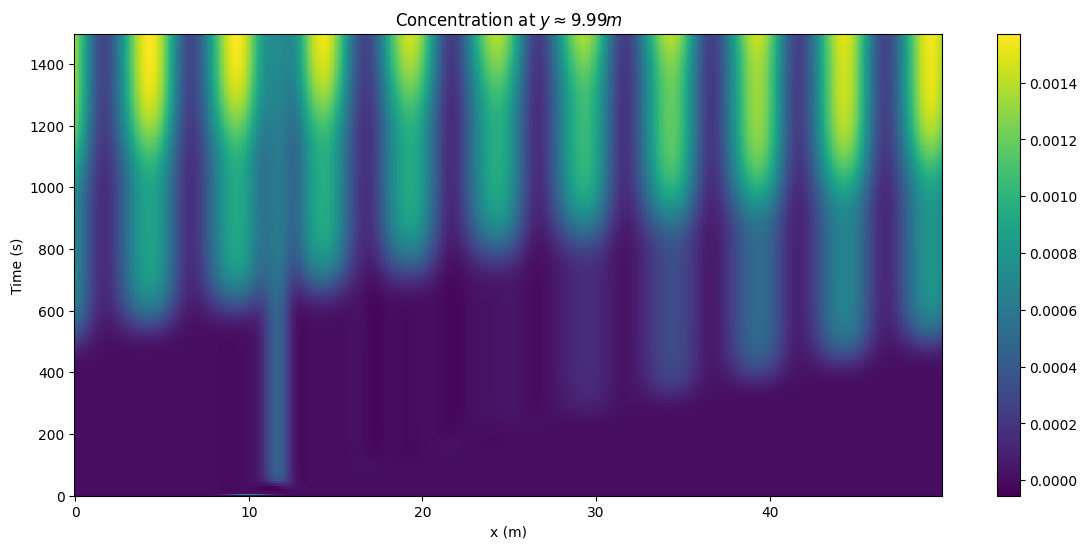

In [33]:
fig, axs = plt.subplots(1, 1, figsize = (14, 6))
c_vals = c_save[:, :, -1]

target = axs.pcolormesh(x.reshape(-1,), t_save, c_vals)
axs.set_ylabel('Time (s)')
axs.set_xlabel('x (m)')
axs.set_title(f'Concentration at $y\\approx {y[0][-1]:.02f}m$')
plt.colorbar(target, ax = axs)

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.